# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

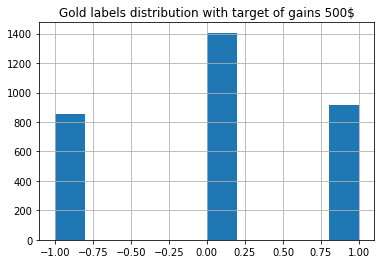

In [12]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

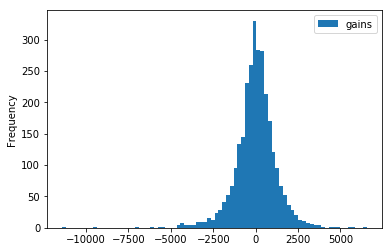

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



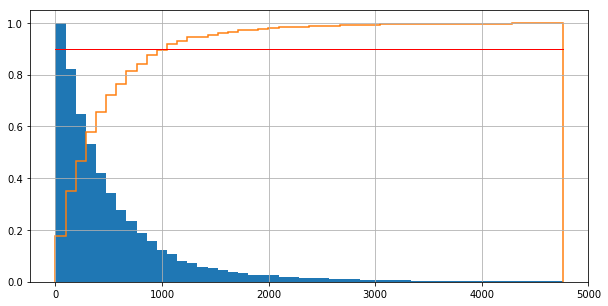

In [18]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

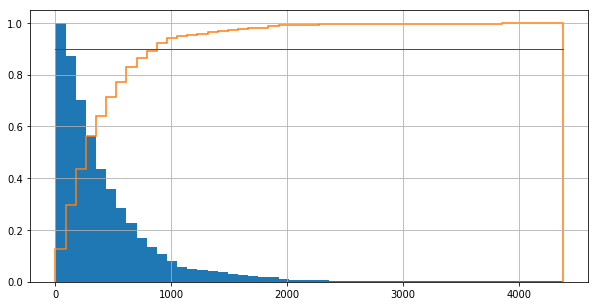

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

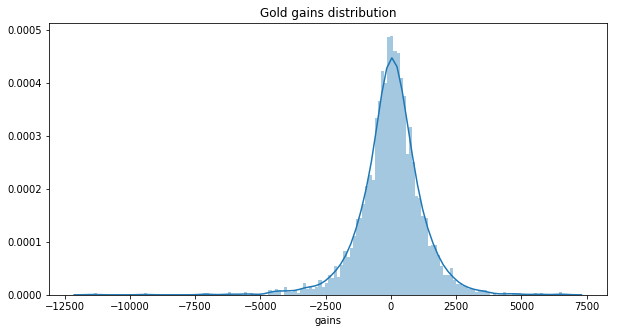

In [22]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

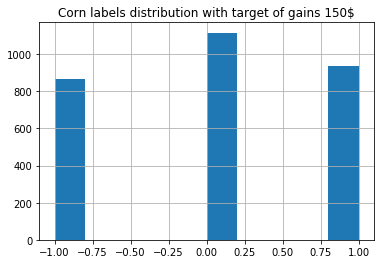

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

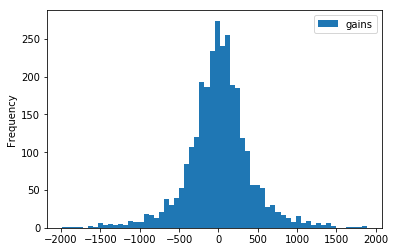

In [26]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

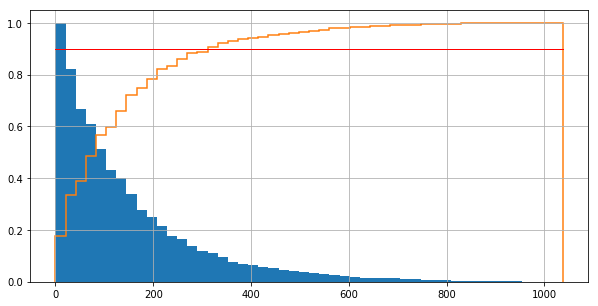

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

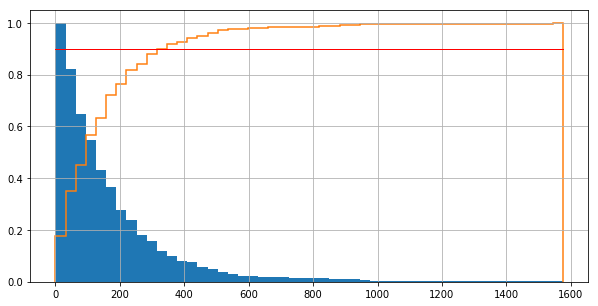

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


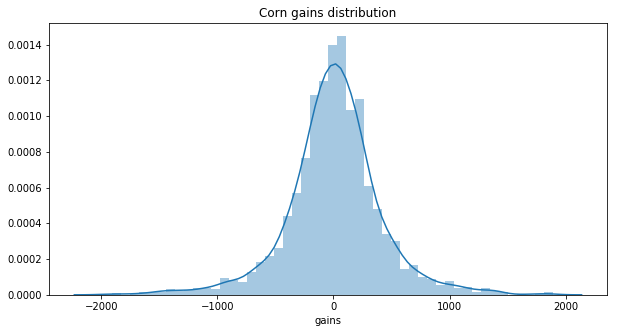

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


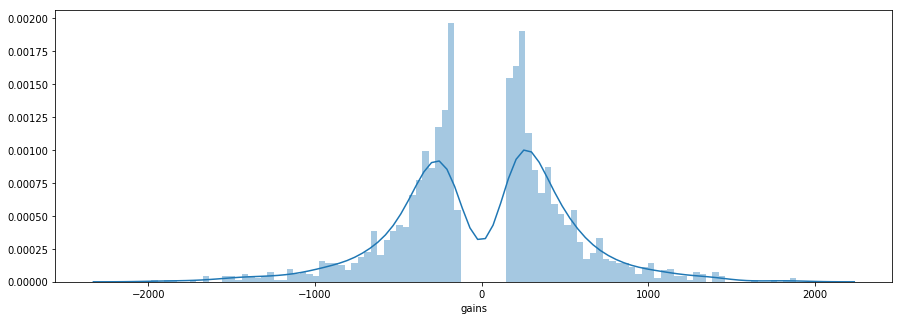

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

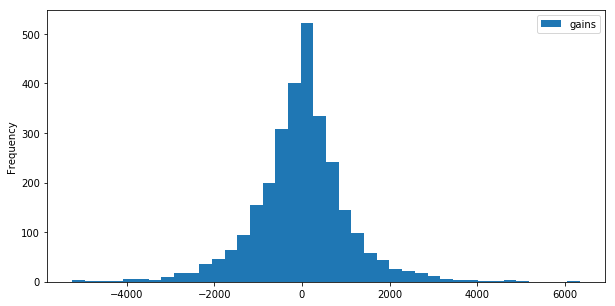

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

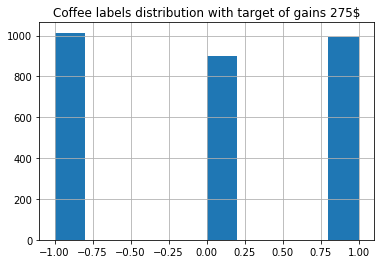

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

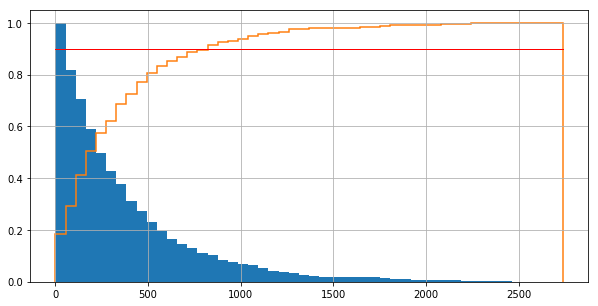

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

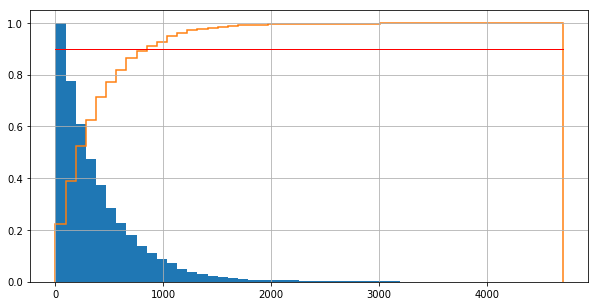

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

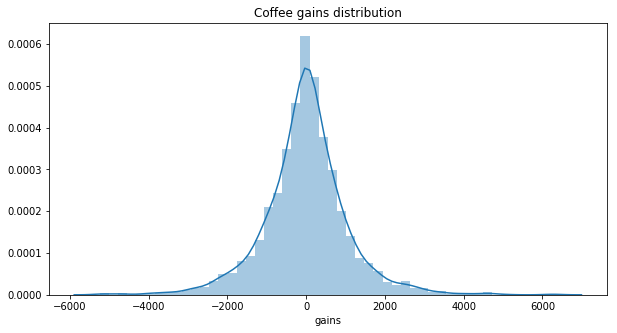

In [39]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

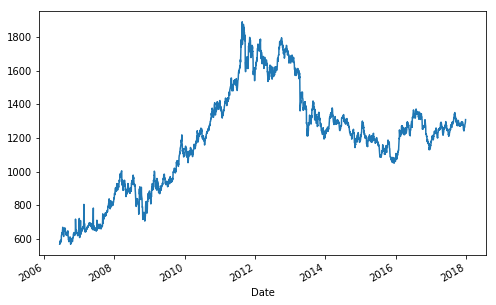

In [40]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

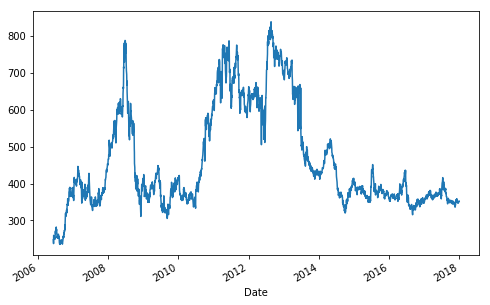

In [41]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

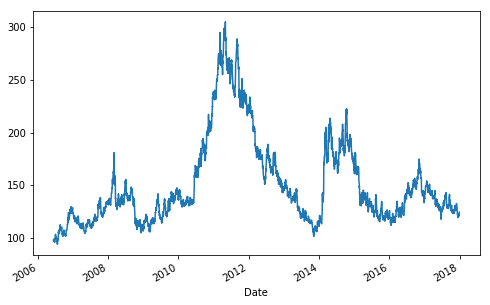

In [42]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [43]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [44]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [45]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [46]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [47]:
gold_data.shape

(2668, 2545)

In [48]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [49]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [50]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [51]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [52]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [53]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [54]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [55]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [56]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [57]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [58]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new', random_state=428)
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new', random_state=912)
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new', random_state=832)
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [59]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 6
inliers: 1927


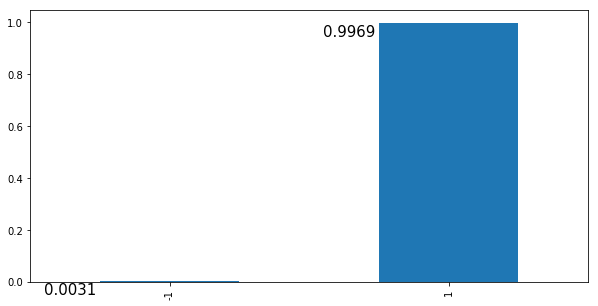

In [60]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [61]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [62]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-09-25 00:00:00
2017-11-14 00:00:00
2017-11-20 00:00:00
2017-12-05 00:00:00
2017-12-22 00:00:00
2017-12-12 00:00:00


outliers: 15
inliers: 1915


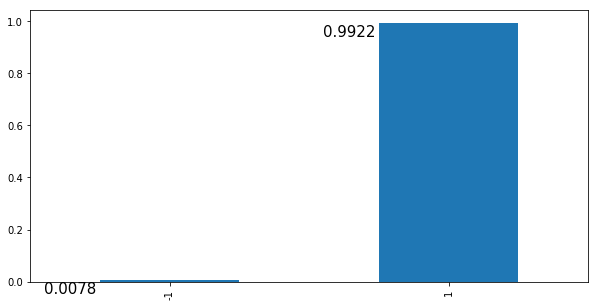

In [63]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [64]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-06-08 00:00:00
2017-09-28 00:00:00
2017-08-01 00:00:00
2017-03-24 00:00:00
2017-11-13 00:00:00
2017-09-01 00:00:00
2017-09-20 00:00:00
2017-10-30 00:00:00
2017-07-10 00:00:00
2017-06-16 00:00:00
2017-06-26 00:00:00
2017-10-10 00:00:00
2017-09-18 00:00:00
2017-11-02 00:00:00
2017-08-02 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 346
inliers: 1577


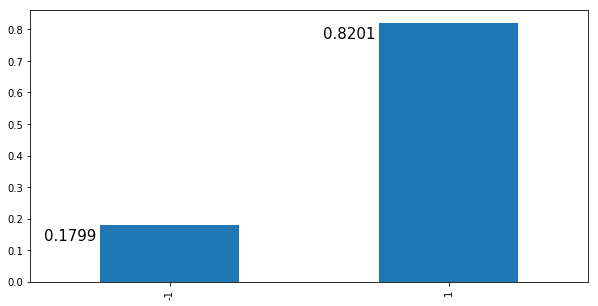

In [65]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [66]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00


In [67]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

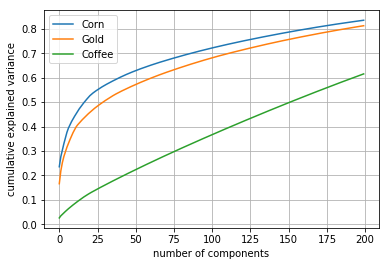

In [68]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [69]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [70]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [71]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.18.0-14-generic-x86_64-with-Ubuntu-18.10-cosmic


In [72]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [137]:
from numpy import size
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


def make_label(v, threshold, fee):
    if abs(v)-fee > threshold:
        if v > 0:
            return 1
        else:
            return -1
    return 0


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False, name=''):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        savefig('figures/' + name + '_kernel_density_residuals.eps')
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        savefig('figures/' + name + '_actual_prediction.eps')
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, regression, name, target)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False, name='', target=0):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    savefig('figures/' + name + '_account.eps')
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if regression:
        label = list(map(lambda x: make_label(x, target, fee), rf.label))
        # print(rf.label)
        # print(label)
    else:
        label = rf.label
    print("Precision score: ", precision_score(label, rf.trade, average=None))
    if not regression:
        # print("Precision score: ", precision_score(list(map(, rf.label)), rf.trade, average=None))
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        savefig('figures/' + name + '_heatmap.eps')
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    savefig('figures/' + name + '_trade_histogram.eps')
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [74]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 1.62038e+06
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.62014e+06
[32]	valid_0's l2: 1.62012e+06
[33]	valid_0's l2: 1.

[301]	valid_0's l2: 1.62218e+06
[302]	valid_0's l2: 1.62224e+06
[303]	valid_0's l2: 1.62222e+06
[304]	valid_0's l2: 1.62219e+06
[305]	valid_0's l2: 1.62217e+06
[306]	valid_0's l2: 1.62215e+06
[307]	valid_0's l2: 1.62213e+06
[308]	valid_0's l2: 1.62218e+06
[309]	valid_0's l2: 1.62216e+06
[310]	valid_0's l2: 1.62218e+06
[311]	valid_0's l2: 1.62223e+06
[312]	valid_0's l2: 1.6223e+06
[313]	valid_0's l2: 1.62232e+06
[314]	valid_0's l2: 1.6223e+06
[315]	valid_0's l2: 1.62228e+06
[316]	valid_0's l2: 1.62229e+06
[317]	valid_0's l2: 1.62235e+06
[318]	valid_0's l2: 1.62242e+06
[319]	valid_0's l2: 1.62239e+06
[320]	valid_0's l2: 1.62244e+06
[321]	valid_0's l2: 1.62242e+06
[322]	valid_0's l2: 1.62244e+06
[323]	valid_0's l2: 1.62247e+06
[324]	valid_0's l2: 1.62245e+06
[325]	valid_0's l2: 1.62249e+06
[326]	valid_0's l2: 1.62247e+06
[327]	valid_0's l2: 1.62251e+06
[328]	valid_0's l2: 1.62249e+06
[329]	valid_0's l2: 1.62255e+06
[330]	valid_0's l2: 1.62252e+06
[331]	valid_0's l2: 1.6225e+06
[332]	valid

[564]	valid_0's l2: 1.62561e+06
[565]	valid_0's l2: 1.62565e+06
[566]	valid_0's l2: 1.62568e+06
[567]	valid_0's l2: 1.62573e+06
[568]	valid_0's l2: 1.62571e+06
[569]	valid_0's l2: 1.62568e+06
[570]	valid_0's l2: 1.62565e+06
[571]	valid_0's l2: 1.6257e+06
[572]	valid_0's l2: 1.62577e+06
[573]	valid_0's l2: 1.62575e+06
[574]	valid_0's l2: 1.62572e+06
[575]	valid_0's l2: 1.62575e+06
[576]	valid_0's l2: 1.62572e+06
[577]	valid_0's l2: 1.62569e+06
[578]	valid_0's l2: 1.62566e+06
[579]	valid_0's l2: 1.62564e+06
[580]	valid_0's l2: 1.62561e+06
[581]	valid_0's l2: 1.62561e+06
[582]	valid_0's l2: 1.62559e+06
[583]	valid_0's l2: 1.62565e+06
[584]	valid_0's l2: 1.62562e+06
[585]	valid_0's l2: 1.62565e+06
[586]	valid_0's l2: 1.62563e+06
[587]	valid_0's l2: 1.62569e+06
[588]	valid_0's l2: 1.62566e+06
[589]	valid_0's l2: 1.62563e+06
[590]	valid_0's l2: 1.62561e+06
[591]	valid_0's l2: 1.62558e+06
[592]	valid_0's l2: 1.62556e+06
[593]	valid_0's l2: 1.62562e+06
[594]	valid_0's l2: 1.6256e+06
[595]	vali

[832]	valid_0's l2: 1.62879e+06
[833]	valid_0's l2: 1.62883e+06
[834]	valid_0's l2: 1.62881e+06
[835]	valid_0's l2: 1.62879e+06
[836]	valid_0's l2: 1.6289e+06
[837]	valid_0's l2: 1.62894e+06
[838]	valid_0's l2: 1.62891e+06
[839]	valid_0's l2: 1.62887e+06
[840]	valid_0's l2: 1.62896e+06
[841]	valid_0's l2: 1.62902e+06
[842]	valid_0's l2: 1.62904e+06
[843]	valid_0's l2: 1.62909e+06
[844]	valid_0's l2: 1.62906e+06
[845]	valid_0's l2: 1.62904e+06
[846]	valid_0's l2: 1.62901e+06
[847]	valid_0's l2: 1.62907e+06
[848]	valid_0's l2: 1.62904e+06
[849]	valid_0's l2: 1.62902e+06
[850]	valid_0's l2: 1.62909e+06
[851]	valid_0's l2: 1.62906e+06
[852]	valid_0's l2: 1.62916e+06
[853]	valid_0's l2: 1.62914e+06
[854]	valid_0's l2: 1.62912e+06
[855]	valid_0's l2: 1.6292e+06
[856]	valid_0's l2: 1.62924e+06
[857]	valid_0's l2: 1.62922e+06
[858]	valid_0's l2: 1.62919e+06
[859]	valid_0's l2: 1.62917e+06
[860]	valid_0's l2: 1.62921e+06
[861]	valid_0's l2: 1.62926e+06
[862]	valid_0's l2: 1.62934e+06
[863]	vali

Predictions/Actual volatility correlation:  0.09617259288031146
Returns  57.29 %
Number of trades:  45
Number of short trades:  27
Number of long trades:  18
Earnings per trade:  127.31
Earnings per short trade:  208.85
Earnings per long trade:  5.00
Precision score:  [0.55555556 0.19806763 0.38888889]


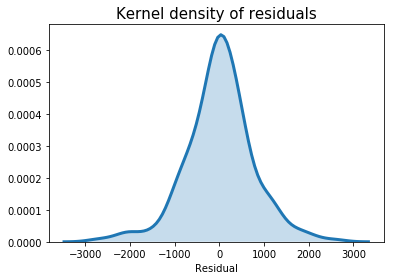

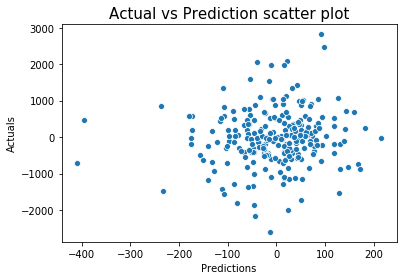

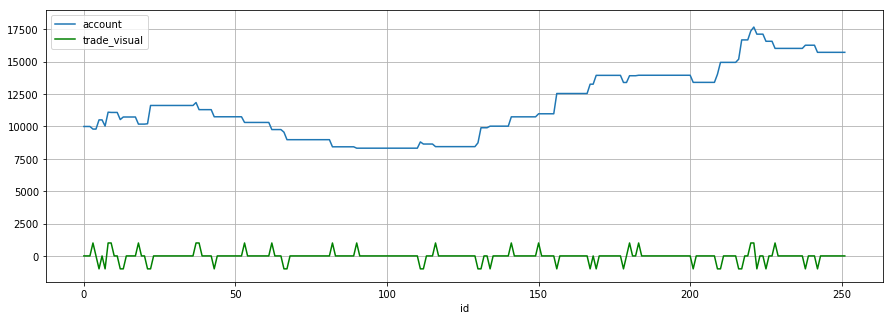

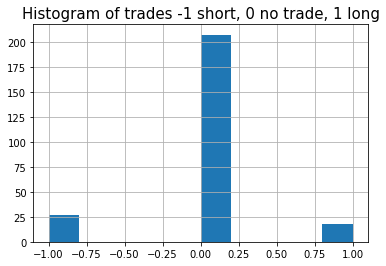

In [106]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=100, name='gold_lgb')

In [76]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 175904
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid_0's l2: 175852
[38]	valid_0's l2: 175849
[39]	valid_0's l2: 17

[333]	valid_0's l2: 175836
[334]	valid_0's l2: 175835
[335]	valid_0's l2: 175840
[336]	valid_0's l2: 175839
[337]	valid_0's l2: 175836
[338]	valid_0's l2: 175834
[339]	valid_0's l2: 175834
[340]	valid_0's l2: 175833
[341]	valid_0's l2: 175831
[342]	valid_0's l2: 175825
[343]	valid_0's l2: 175821
[344]	valid_0's l2: 175821
[345]	valid_0's l2: 175829
[346]	valid_0's l2: 175833
[347]	valid_0's l2: 175833
[348]	valid_0's l2: 175843
[349]	valid_0's l2: 175841
[350]	valid_0's l2: 175840
[351]	valid_0's l2: 175838
[352]	valid_0's l2: 175832
[353]	valid_0's l2: 175834
[354]	valid_0's l2: 175834
[355]	valid_0's l2: 175834
[356]	valid_0's l2: 175831
[357]	valid_0's l2: 175831
[358]	valid_0's l2: 175828
[359]	valid_0's l2: 175827
[360]	valid_0's l2: 175829
[361]	valid_0's l2: 175829
[362]	valid_0's l2: 175826
[363]	valid_0's l2: 175826
[364]	valid_0's l2: 175825
[365]	valid_0's l2: 175819
[366]	valid_0's l2: 175819
[367]	valid_0's l2: 175819
[368]	valid_0's l2: 175822
[369]	valid_0's l2: 175822
[

[642]	valid_0's l2: 175865
[643]	valid_0's l2: 175869
[644]	valid_0's l2: 175868
[645]	valid_0's l2: 175873
[646]	valid_0's l2: 175874
[647]	valid_0's l2: 175878
[648]	valid_0's l2: 175883
[649]	valid_0's l2: 175882
[650]	valid_0's l2: 175881
[651]	valid_0's l2: 175886
[652]	valid_0's l2: 175885
[653]	valid_0's l2: 175884
[654]	valid_0's l2: 175884
[655]	valid_0's l2: 175894
[656]	valid_0's l2: 175896
[657]	valid_0's l2: 175895
[658]	valid_0's l2: 175897
[659]	valid_0's l2: 175896
[660]	valid_0's l2: 175901
[661]	valid_0's l2: 175900
[662]	valid_0's l2: 175902
[663]	valid_0's l2: 175901
[664]	valid_0's l2: 175900
[665]	valid_0's l2: 175899
[666]	valid_0's l2: 175899
[667]	valid_0's l2: 175898
[668]	valid_0's l2: 175897
[669]	valid_0's l2: 175900
[670]	valid_0's l2: 175904
[671]	valid_0's l2: 175903
[672]	valid_0's l2: 175907
[673]	valid_0's l2: 175906
[674]	valid_0's l2: 175907
[675]	valid_0's l2: 175911
[676]	valid_0's l2: 175916
[677]	valid_0's l2: 175919
[678]	valid_0's l2: 175918
[

[982]	valid_0's l2: 175878
[983]	valid_0's l2: 175875
[984]	valid_0's l2: 175866
[985]	valid_0's l2: 175864
[986]	valid_0's l2: 175864
[987]	valid_0's l2: 175862
[988]	valid_0's l2: 175861
[989]	valid_0's l2: 175860
[990]	valid_0's l2: 175859
[991]	valid_0's l2: 175867
[992]	valid_0's l2: 175869
[993]	valid_0's l2: 175868
[994]	valid_0's l2: 175878
[995]	valid_0's l2: 175877
[996]	valid_0's l2: 175885
[997]	valid_0's l2: 175889
[998]	valid_0's l2: 175888
[999]	valid_0's l2: 175879
[1000]	valid_0's l2: 175878


Predictions/Actual volatility correlation:  0.030004906267008552
Returns  2.48 %
Number of trades:  36
Number of short trades:  14
Number of long trades:  22
Earnings per trade:  6.89
Earnings per short trade:  43.29
Earnings per long trade:  -16.28
Precision score:  [0.64285714 0.1712963  0.40909091]


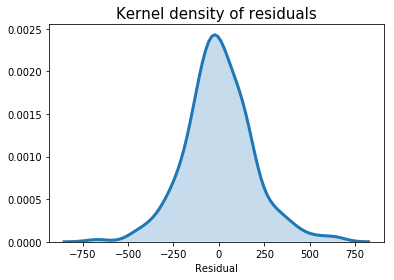

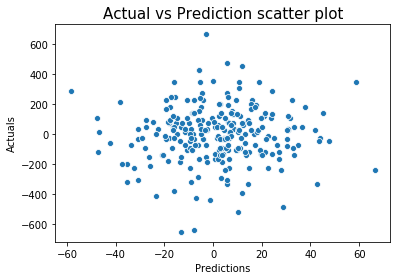

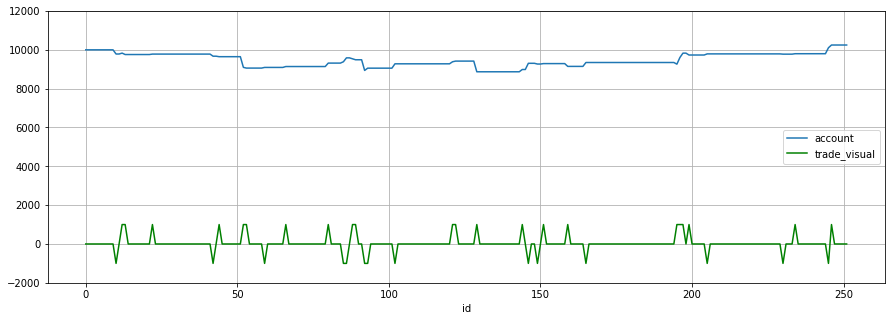

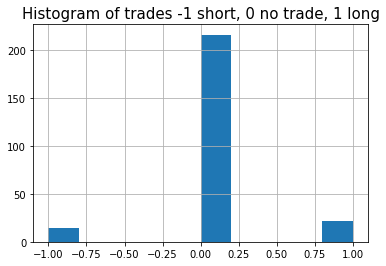

In [107]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=30, name='corn_lgb')

In [78]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test)

coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's l2: 161691
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid_0's l2: 161690
[38]	valid_0's l2: 161688
[39]	valid_0's l2: 16

[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[349]	valid_0's l2: 161421
[350]	valid_0's l2: 161422
[351]	valid_0's l2: 161421
[352]	valid_0's l2: 161426
[353]	valid_0's l2: 161418
[354]	valid_0's l2: 161419
[355]	valid_0's l2: 161420
[356]	valid_0's l2: 161416
[357]	valid_0's l2: 161417
[358]	valid_0's l2: 161421
[359]	valid_0's l2: 161421
[360]	valid_0's l2: 161424
[361]	valid_0's l2: 161416
[362]	valid_0's l2: 161420
[363]	valid_0's l2: 161421
[364]	valid_0's l2: 161422
[365]	valid_0's l2: 161413
[366]	valid_0's l2: 161414
[367]	valid_0's l2: 161415
[368]	valid_0's l2: 161412
[369]	valid_0's l2: 161414
[370]	valid_0's l2: 161421
[371]	valid_0's l2: 161422
[372]	valid_0's l2: 161427
[373]	valid_0's l2: 161418
[

[669]	valid_0's l2: 161770
[670]	valid_0's l2: 161776
[671]	valid_0's l2: 161775
[672]	valid_0's l2: 161773
[673]	valid_0's l2: 161773
[674]	valid_0's l2: 161782
[675]	valid_0's l2: 161788
[676]	valid_0's l2: 161799
[677]	valid_0's l2: 161798
[678]	valid_0's l2: 161797
[679]	valid_0's l2: 161795
[680]	valid_0's l2: 161805
[681]	valid_0's l2: 161804
[682]	valid_0's l2: 161803
[683]	valid_0's l2: 161797
[684]	valid_0's l2: 161809
[685]	valid_0's l2: 161807
[686]	valid_0's l2: 161815
[687]	valid_0's l2: 161815
[688]	valid_0's l2: 161814
[689]	valid_0's l2: 161814
[690]	valid_0's l2: 161826
[691]	valid_0's l2: 161825
[692]	valid_0's l2: 161823
[693]	valid_0's l2: 161830
[694]	valid_0's l2: 161828
[695]	valid_0's l2: 161828
[696]	valid_0's l2: 161836
[697]	valid_0's l2: 161834
[698]	valid_0's l2: 161840
[699]	valid_0's l2: 161839
[700]	valid_0's l2: 161849
[701]	valid_0's l2: 161849
[702]	valid_0's l2: 161859
[703]	valid_0's l2: 161859
[704]	valid_0's l2: 161859
[705]	valid_0's l2: 161858
[

[978]	valid_0's l2: 162191
[979]	valid_0's l2: 162190
[980]	valid_0's l2: 162198
[981]	valid_0's l2: 162197
[982]	valid_0's l2: 162195
[983]	valid_0's l2: 162191
[984]	valid_0's l2: 162189
[985]	valid_0's l2: 162188
[986]	valid_0's l2: 162188
[987]	valid_0's l2: 162186
[988]	valid_0's l2: 162196
[989]	valid_0's l2: 162195
[990]	valid_0's l2: 162195
[991]	valid_0's l2: 162192
[992]	valid_0's l2: 162200
[993]	valid_0's l2: 162199
[994]	valid_0's l2: 162210
[995]	valid_0's l2: 162209
[996]	valid_0's l2: 162211
[997]	valid_0's l2: 162211
[998]	valid_0's l2: 162210
[999]	valid_0's l2: 162212
[1000]	valid_0's l2: 162212


Predictions/Actual volatility correlation:  -0.03164539084652848
Returns  34.10 %
Number of trades:  45
Number of short trades:  30
Number of long trades:  15
Earnings per trade:  75.78
Earnings per short trade:  158.71
Earnings per long trade:  -90.07
Precision score:  [0.46666667 0.0821256  0.26666667]


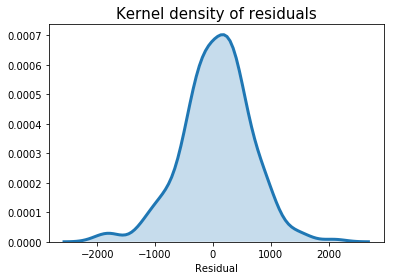

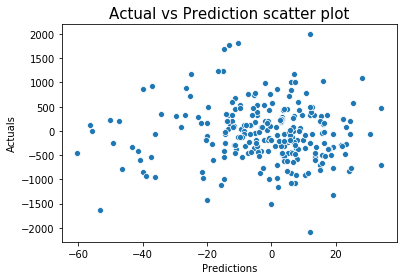

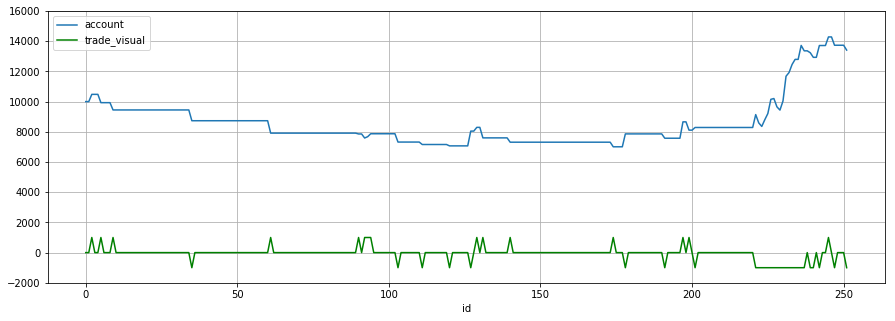

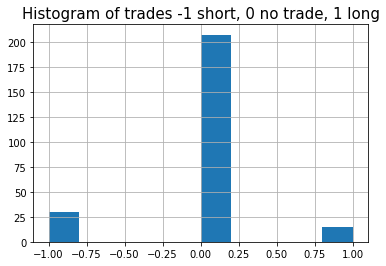

In [108]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=20, name='coffee_lgb')

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee    | -100    | -90.6              | 111              |

In [84]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [85]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

In [86]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 200
model = define_model(input_shape, num_classes)

Using TensorFlow backend.


In [87]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [88]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1927 samples, validate on 484 samples
Epoch 1/200
1927/1927 [==============================] - 1s 605us/step - loss: 71732292409.7893 - acc: 0.3451 - val_loss: 67898032356.4959 - val_acc: 0.2975

Epoch 00001: val_loss improved from inf to 67898032356.49586, saving model to saved_models/weights.gold.hdf5
Epoch 2/200
1927/1927 [==============================] - 0s 118us/step - loss: 65714174377.1168 - acc: 0.3155 - val_loss: 62184780080.6612 - val_acc: 0.3017

Epoch 00002: val_loss improved from 67898032356.49586 to 62184780080.66116, saving model to saved_models/weights.gold.hdf5
Epoch 3/200
1927/1927 [==============================] - 0s 117us/step - loss: 60075965405.4593 - acc: 0.3254 - val_loss: 56782944196.7603 - val_acc: 0.2996

Epoch 00003: val_loss improved from 62184780080.66116 to 56782944196.76033, saving model to saved_models/weights.gold.hdf5
Epoch 4/200
1927/1927 [==============================] - 0s 120us/step - loss: 54734866651.9979 - acc: 0.3389 - val_loss: 51

1927/1927 [==============================] - 0s 112us/step - loss: 2178747551.4188 - acc: 0.3238 - val_loss: 1915477893.2893 - val_acc: 0.3058

Epoch 00030: val_loss improved from 2363782858.31405 to 1915477893.28926, saving model to saved_models/weights.gold.hdf5
Epoch 31/200
1927/1927 [==============================] - 0s 109us/step - loss: 1749614847.3025 - acc: 0.3223 - val_loss: 1521346400.0000 - val_acc: 0.3079

Epoch 00031: val_loss improved from 1915477893.28926 to 1521346400.00000, saving model to saved_models/weights.gold.hdf5
Epoch 32/200
1927/1927 [==============================] - 0s 108us/step - loss: 1375424567.8630 - acc: 0.3186 - val_loss: 1180960667.5041 - val_acc: 0.3120

Epoch 00032: val_loss improved from 1521346400.00000 to 1180960667.50413, saving model to saved_models/weights.gold.hdf5
Epoch 33/200
1927/1927 [==============================] - 0s 106us/step - loss: 1055427070.0405 - acc: 0.3088 - val_loss: 889455124.6281 - val_acc: 0.3161

Epoch 00033: val_loss i

1927/1927 [==============================] - 0s 105us/step - loss: 180827.9294 - acc: 0.3191 - val_loss: 174501.5462 - val_acc: 0.3450

Epoch 00064: val_loss did not improve from 162151.63653
Epoch 65/200
1927/1927 [==============================] - 0s 106us/step - loss: 181023.1987 - acc: 0.3093 - val_loss: 166096.4688 - val_acc: 0.3306

Epoch 00065: val_loss did not improve from 162151.63653
Epoch 66/200
1927/1927 [==============================] - 0s 105us/step - loss: 183168.4769 - acc: 0.3300 - val_loss: 170090.3771 - val_acc: 0.3182

Epoch 00066: val_loss did not improve from 162151.63653
Epoch 67/200
1927/1927 [==============================] - 0s 103us/step - loss: 184070.2795 - acc: 0.3155 - val_loss: 183721.2437 - val_acc: 0.3347

Epoch 00067: val_loss did not improve from 162151.63653
Epoch 68/200
1927/1927 [==============================] - 0s 133us/step - loss: 183301.4143 - acc: 0.3472 - val_loss: 172659.1465 - val_acc: 0.3430

Epoch 00068: val_loss did not improve from 1

1927/1927 [==============================] - 0s 106us/step - loss: 183547.3325 - acc: 0.3254 - val_loss: 181036.0869 - val_acc: 0.2665

Epoch 00103: val_loss did not improve from 151695.85760
Epoch 104/200
1927/1927 [==============================] - 0s 104us/step - loss: 181427.6840 - acc: 0.3280 - val_loss: 173681.3719 - val_acc: 0.3471

Epoch 00104: val_loss did not improve from 151695.85760
Epoch 105/200
1927/1927 [==============================] - 0s 102us/step - loss: 181450.6490 - acc: 0.3311 - val_loss: 164539.7987 - val_acc: 0.3202

Epoch 00105: val_loss did not improve from 151695.85760
Epoch 106/200
1927/1927 [==============================] - 0s 106us/step - loss: 185135.5996 - acc: 0.3275 - val_loss: 160588.8168 - val_acc: 0.3182

Epoch 00106: val_loss did not improve from 151695.85760
Epoch 107/200
1927/1927 [==============================] - 0s 104us/step - loss: 182316.5325 - acc: 0.3337 - val_loss: 197056.4956 - val_acc: 0.3533

Epoch 00107: val_loss did not improve fr

1927/1927 [==============================] - 0s 112us/step - loss: 180374.4434 - acc: 0.3181 - val_loss: 191773.6785 - val_acc: 0.3223

Epoch 00143: val_loss did not improve from 151695.85760
Epoch 144/200
1927/1927 [==============================] - 0s 100us/step - loss: 183074.6797 - acc: 0.3295 - val_loss: 207166.3768 - val_acc: 0.3017

Epoch 00144: val_loss did not improve from 151695.85760
Epoch 145/200
1927/1927 [==============================] - 0s 103us/step - loss: 182330.6439 - acc: 0.3285 - val_loss: 185183.9553 - val_acc: 0.2955

Epoch 00145: val_loss did not improve from 151695.85760
Epoch 146/200
1927/1927 [==============================] - 0s 109us/step - loss: 183914.9992 - acc: 0.3332 - val_loss: 189826.0082 - val_acc: 0.3657

Epoch 00146: val_loss did not improve from 151695.85760
Epoch 147/200
1927/1927 [==============================] - 0s 102us/step - loss: 182503.9734 - acc: 0.3223 - val_loss: 161893.0087 - val_acc: 0.3326

Epoch 00147: val_loss did not improve fr

1927/1927 [==============================] - 0s 127us/step - loss: 181769.4757 - acc: 0.3197 - val_loss: 185198.2354 - val_acc: 0.3595

Epoch 00183: val_loss did not improve from 151695.85760
Epoch 184/200
1927/1927 [==============================] - 0s 112us/step - loss: 181044.9525 - acc: 0.3223 - val_loss: 190490.8512 - val_acc: 0.3719

Epoch 00184: val_loss did not improve from 151695.85760
Epoch 185/200
1927/1927 [==============================] - 0s 120us/step - loss: 182413.5863 - acc: 0.3238 - val_loss: 166017.2895 - val_acc: 0.3967

Epoch 00185: val_loss did not improve from 151695.85760
Epoch 186/200
1927/1927 [==============================] - 0s 127us/step - loss: 184815.5952 - acc: 0.3394 - val_loss: 193085.4188 - val_acc: 0.3616

Epoch 00186: val_loss did not improve from 151695.85760
Epoch 187/200
1927/1927 [==============================] - 0s 128us/step - loss: 181946.8343 - acc: 0.3451 - val_loss: 176466.2013 - val_acc: 0.3905

Epoch 00187: val_loss did not improve fr

In [89]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  63.45 %
Number of trades:  173
Number of short trades:  9
Number of long trades:  164
Earnings per trade:  36.68
Earnings per short trade:  -91.17
Earnings per long trade:  43.69
Precision score:  [0.11111111 0.55696203 0.20731707]


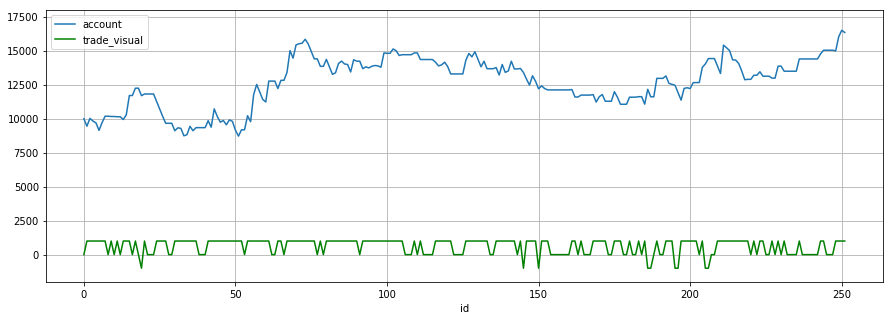

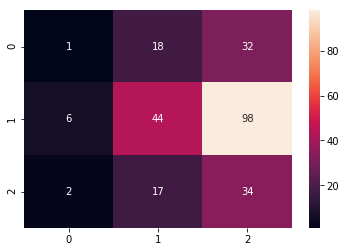

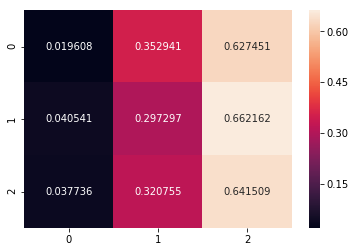

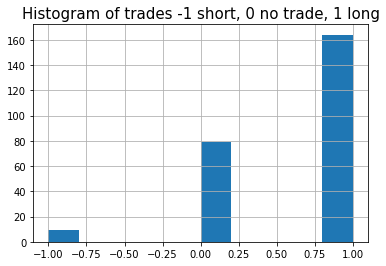

In [115]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_nn_cls', regression=False)

In [91]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1928 samples, validate on 483 samples
Epoch 1/200
1928/1928 [==============================] - 1s 569us/step - loss: 68949180348.0166 - acc: 0.3304 - val_loss: 64729317821.2174 - val_acc: 0.3313

Epoch 00001: val_loss improved from inf to 64729317821.21739, saving model to saved_models/weights.corn.hdf5
Epoch 2/200
1928/1928 [==============================] - 0s 127us/step - loss: 62359400881.3942 - acc: 0.3356 - val_loss: 58523481217.3251 - val_acc: 0.3230

Epoch 00002: val_loss improved from 64729317821.21739 to 58523481217.32505, saving model to saved_models/weights.corn.hdf5
Epoch 3/200
1928/1928 [==============================] - 0s 126us/step - loss: 56314453157.7095 - acc: 0.3143 - val_loss: 52791634098.0870 - val_acc: 0.3251

Epoch 00003: val_loss improved from 58523481217.32505 to 52791634098.08696, saving model to saved_models/weights.corn.hdf5
Epoch 4/200
1928/1928 [==============================] - 0s 113us/step - loss: 50730433591.2365 - acc: 0.3226 - val_loss: 47

1928/1928 [==============================] - 0s 101us/step - loss: 1917564007.5685 - acc: 0.3205 - val_loss: 1686640509.3499 - val_acc: 0.3230

Epoch 00030: val_loss improved from 2053188073.47412 to 1686640509.34990, saving model to saved_models/weights.corn.hdf5
Epoch 31/200
1928/1928 [==============================] - 0s 101us/step - loss: 1565479594.7552 - acc: 0.3195 - val_loss: 1359774645.3996 - val_acc: 0.3188

Epoch 00031: val_loss improved from 1686640509.34990 to 1359774645.39959, saving model to saved_models/weights.corn.hdf5
Epoch 32/200
1928/1928 [==============================] - 0s 98us/step - loss: 1251800537.7593 - acc: 0.3309 - val_loss: 1075048542.8406 - val_acc: 0.3313

Epoch 00032: val_loss improved from 1359774645.39959 to 1075048542.84058, saving model to saved_models/weights.corn.hdf5
Epoch 33/200
1928/1928 [==============================] - 0s 105us/step - loss: 982621866.8880 - acc: 0.3356 - val_loss: 827914478.6253 - val_acc: 0.3375

Epoch 00033: val_loss imp

1928/1928 [==============================] - 0s 109us/step - loss: 155840.9475 - acc: 0.3345 - val_loss: 152073.8009 - val_acc: 0.2857

Epoch 00065: val_loss did not improve from 132144.46050
Epoch 66/200
1928/1928 [==============================] - 0s 102us/step - loss: 156490.6695 - acc: 0.3138 - val_loss: 156688.0328 - val_acc: 0.3354

Epoch 00066: val_loss did not improve from 132144.46050
Epoch 67/200
1928/1928 [==============================] - 0s 103us/step - loss: 158189.6477 - acc: 0.3371 - val_loss: 149988.3725 - val_acc: 0.3085

Epoch 00067: val_loss did not improve from 132144.46050
Epoch 68/200
1928/1928 [==============================] - 0s 102us/step - loss: 155498.6343 - acc: 0.3096 - val_loss: 138552.4994 - val_acc: 0.3499

Epoch 00068: val_loss did not improve from 132144.46050
Epoch 69/200
1928/1928 [==============================] - 0s 102us/step - loss: 155181.6082 - acc: 0.3164 - val_loss: 148999.6983 - val_acc: 0.3520

Epoch 00069: val_loss did not improve from 1

1928/1928 [==============================] - 0s 105us/step - loss: 156547.5908 - acc: 0.3226 - val_loss: 144995.8701 - val_acc: 0.3230

Epoch 00105: val_loss did not improve from 132144.46050
Epoch 106/200
1928/1928 [==============================] - 0s 103us/step - loss: 155490.5360 - acc: 0.3304 - val_loss: 144105.2763 - val_acc: 0.2567

Epoch 00106: val_loss did not improve from 132144.46050
Epoch 107/200
1928/1928 [==============================] - 0s 104us/step - loss: 158740.4020 - acc: 0.3283 - val_loss: 151890.8654 - val_acc: 0.2878

Epoch 00107: val_loss did not improve from 132144.46050
Epoch 108/200
1928/1928 [==============================] - 0s 103us/step - loss: 155963.8182 - acc: 0.3402 - val_loss: 147388.3834 - val_acc: 0.3043

Epoch 00108: val_loss did not improve from 132144.46050
Epoch 109/200
1928/1928 [==============================] - 0s 104us/step - loss: 156833.6244 - acc: 0.3231 - val_loss: 147395.4282 - val_acc: 0.3002

Epoch 00109: val_loss did not improve fr


Epoch 00144: val_loss did not improve from 127782.62511
Epoch 145/200
1928/1928 [==============================] - 0s 102us/step - loss: 155901.3983 - acc: 0.3179 - val_loss: 146500.5750 - val_acc: 0.2981

Epoch 00145: val_loss did not improve from 127782.62511
Epoch 146/200
1928/1928 [==============================] - 0s 99us/step - loss: 153550.5420 - acc: 0.3242 - val_loss: 170241.1327 - val_acc: 0.2774

Epoch 00146: val_loss did not improve from 127782.62511
Epoch 147/200
1928/1928 [==============================] - 0s 99us/step - loss: 156119.0496 - acc: 0.3314 - val_loss: 155768.4238 - val_acc: 0.3292

Epoch 00147: val_loss did not improve from 127782.62511
Epoch 148/200
1928/1928 [==============================] - 0s 104us/step - loss: 155806.1742 - acc: 0.3304 - val_loss: 141378.0047 - val_acc: 0.3416

Epoch 00148: val_loss did not improve from 127782.62511
Epoch 149/200
1928/1928 [==============================] - 0s 107us/step - loss: 156299.9957 - acc: 0.3071 - val_loss: 15

1928/1928 [==============================] - 0s 115us/step - loss: 156889.5540 - acc: 0.3081 - val_loss: 157271.2090 - val_acc: 0.3251

Epoch 00184: val_loss did not improve from 124657.74258
Epoch 185/200
1928/1928 [==============================] - 0s 105us/step - loss: 157584.1380 - acc: 0.3174 - val_loss: 159629.7134 - val_acc: 0.3271

Epoch 00185: val_loss did not improve from 124657.74258
Epoch 186/200
1928/1928 [==============================] - 0s 105us/step - loss: 154891.2274 - acc: 0.3351 - val_loss: 149298.2566 - val_acc: 0.2795

Epoch 00186: val_loss did not improve from 124657.74258
Epoch 187/200
1928/1928 [==============================] - 0s 107us/step - loss: 155991.8058 - acc: 0.3237 - val_loss: 166659.9348 - val_acc: 0.3023

Epoch 00187: val_loss did not improve from 124657.74258
Epoch 188/200
1928/1928 [==============================] - 0s 106us/step - loss: 153523.0701 - acc: 0.3262 - val_loss: 183913.6328 - val_acc: 0.3458

Epoch 00188: val_loss did not improve fr

Returns  -57.45 %
Number of trades:  185
Number of short trades:  142
Number of long trades:  43
Earnings per trade:  -31.05
Earnings per short trade:  -28.63
Earnings per long trade:  -39.04
Precision score:  [0.14788732 0.65671642 0.18604651]


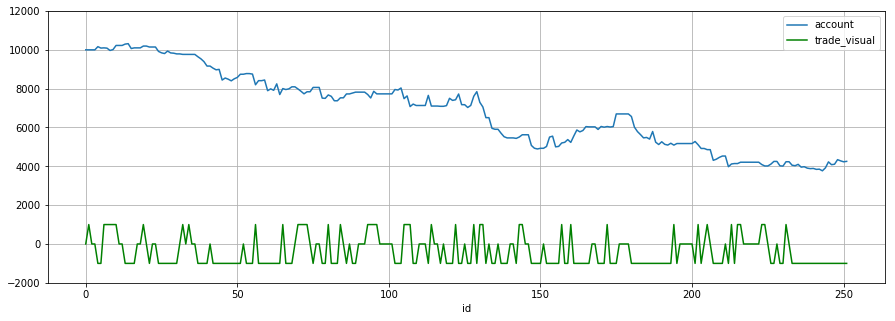

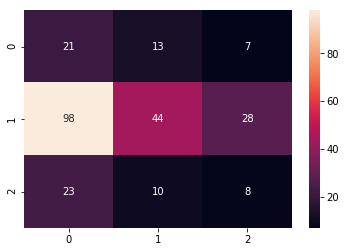

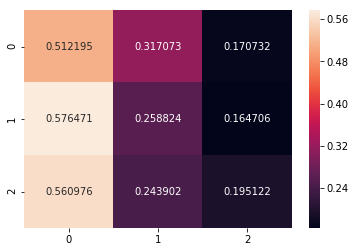

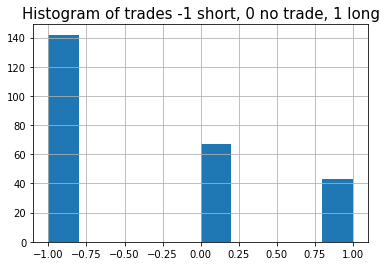

In [116]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_nn_cls')

In [93]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/200
1923/1923 [==============================] - 1s 631us/step - loss: 4455395626.7207 - acc: 0.3593 - val_loss: 4321223393.5301 - val_acc: 0.3472

Epoch 00001: val_loss improved from inf to 4321223393.53015, saving model to saved_models/weights.coffee.hdf5
Epoch 2/200
1923/1923 [==============================] - 0s 120us/step - loss: 4296069813.6287 - acc: 0.3453 - val_loss: 4169665823.6674 - val_acc: 0.3534

Epoch 00002: val_loss improved from 4321223393.53015 to 4169665823.66736, saving model to saved_models/weights.coffee.hdf5
Epoch 3/200
1923/1923 [==============================] - 0s 119us/step - loss: 4132251523.3947 - acc: 0.3526 - val_loss: 4022707756.1746 - val_acc: 0.3472

Epoch 00003: val_loss improved from 4169665823.66736 to 4022707756.17464, saving model to saved_models/weights.coffee.hdf5
Epoch 4/200
1923/1923 [==============================] - 0s 122us/step - loss: 4001564311.5673 - acc: 0.3547 - val_loss: 38801419

1923/1923 [==============================] - 0s 133us/step - loss: 1403963631.3926 - acc: 0.3510 - val_loss: 1342215571.3597 - val_acc: 0.3451

Epoch 00030: val_loss improved from 1410640588.04158 to 1342215571.35967, saving model to saved_models/weights.coffee.hdf5
Epoch 31/200
1923/1923 [==============================] - 0s 120us/step - loss: 1333419442.4878 - acc: 0.3365 - val_loss: 1275960764.0083 - val_acc: 0.3555

Epoch 00031: val_loss improved from 1342215571.35967 to 1275960764.00832, saving model to saved_models/weights.coffee.hdf5
Epoch 32/200
1923/1923 [==============================] - 0s 114us/step - loss: 1269936133.7077 - acc: 0.3515 - val_loss: 1211420802.5281 - val_acc: 0.3721

Epoch 00032: val_loss improved from 1275960764.00832 to 1211420802.52807, saving model to saved_models/weights.coffee.hdf5
Epoch 33/200
1923/1923 [==============================] - 0s 113us/step - loss: 1203266311.8710 - acc: 0.3578 - val_loss: 1148954062.5696 - val_acc: 0.3493

Epoch 00033: val

1923/1923 [==============================] - 0s 107us/step - loss: 124600257.2626 - acc: 0.3354 - val_loss: 108779158.5572 - val_acc: 0.3160

Epoch 00060: val_loss improved from 126557797.50936 to 108779158.55717, saving model to saved_models/weights.coffee.hdf5
Epoch 61/200
1923/1923 [==============================] - 0s 104us/step - loss: 107216342.9990 - acc: 0.3422 - val_loss: 92476087.4387 - val_acc: 0.3264

Epoch 00061: val_loss improved from 108779158.55717 to 92476087.43867, saving model to saved_models/weights.coffee.hdf5
Epoch 62/200
1923/1923 [==============================] - 0s 109us/step - loss: 90458793.2605 - acc: 0.3318 - val_loss: 77352061.6549 - val_acc: 0.3077

Epoch 00062: val_loss improved from 92476087.43867 to 77352061.65489, saving model to saved_models/weights.coffee.hdf5
Epoch 63/200
1923/1923 [==============================] - 0s 109us/step - loss: 75936762.6008 - acc: 0.3630 - val_loss: 63871505.1040 - val_acc: 0.2994

Epoch 00063: val_loss improved from 77

1923/1923 [==============================] - 0s 103us/step - loss: 51344.0610 - acc: 0.3276 - val_loss: 54007.3900 - val_acc: 0.2931

Epoch 00093: val_loss did not improve from 47674.53801
Epoch 94/200
1923/1923 [==============================] - 0s 104us/step - loss: 49683.1467 - acc: 0.3209 - val_loss: 56396.9556 - val_acc: 0.2994

Epoch 00094: val_loss did not improve from 47674.53801
Epoch 95/200
1923/1923 [==============================] - 0s 113us/step - loss: 53751.8064 - acc: 0.3292 - val_loss: 54120.8260 - val_acc: 0.2848

Epoch 00095: val_loss did not improve from 47674.53801
Epoch 96/200
1923/1923 [==============================] - 0s 106us/step - loss: 52433.6558 - acc: 0.3276 - val_loss: 50813.1938 - val_acc: 0.2911

Epoch 00096: val_loss did not improve from 47674.53801
Epoch 97/200
1923/1923 [==============================] - 0s 105us/step - loss: 52172.9233 - acc: 0.3339 - val_loss: 51850.3552 - val_acc: 0.3015

Epoch 00097: val_loss did not improve from 47674.53801
Epo

1923/1923 [==============================] - 0s 110us/step - loss: 51165.0521 - acc: 0.3146 - val_loss: 55537.2849 - val_acc: 0.2516

Epoch 00133: val_loss did not improve from 47506.46366
Epoch 134/200
1923/1923 [==============================] - 0s 113us/step - loss: 52526.5359 - acc: 0.3105 - val_loss: 51459.1124 - val_acc: 0.2765

Epoch 00134: val_loss did not improve from 47506.46366
Epoch 135/200
1923/1923 [==============================] - 0s 110us/step - loss: 51191.4642 - acc: 0.3255 - val_loss: 53057.6374 - val_acc: 0.2640

Epoch 00135: val_loss did not improve from 47506.46366
Epoch 136/200
1923/1923 [==============================] - 0s 106us/step - loss: 53934.2494 - acc: 0.3162 - val_loss: 48391.9890 - val_acc: 0.2765

Epoch 00136: val_loss did not improve from 47506.46366
Epoch 137/200
1923/1923 [==============================] - 0s 107us/step - loss: 50056.6752 - acc: 0.3177 - val_loss: 51597.8847 - val_acc: 0.2703

Epoch 00137: val_loss did not improve from 47506.46366

1923/1923 [==============================] - 0s 111us/step - loss: 50743.3820 - acc: 0.3120 - val_loss: 53282.7118 - val_acc: 0.2599

Epoch 00173: val_loss did not improve from 46591.79996
Epoch 174/200
1923/1923 [==============================] - 0s 102us/step - loss: 52558.2922 - acc: 0.2985 - val_loss: 53209.3456 - val_acc: 0.2620

Epoch 00174: val_loss did not improve from 46591.79996
Epoch 175/200
1923/1923 [==============================] - 0s 102us/step - loss: 48767.4384 - acc: 0.2990 - val_loss: 57029.1686 - val_acc: 0.2557

Epoch 00175: val_loss did not improve from 46591.79996
Epoch 176/200
1923/1923 [==============================] - 0s 105us/step - loss: 53774.4362 - acc: 0.2897 - val_loss: 51649.9082 - val_acc: 0.2682

Epoch 00176: val_loss did not improve from 46591.79996
Epoch 177/200
1923/1923 [==============================] - 0s 107us/step - loss: 51052.5339 - acc: 0.2923 - val_loss: 54211.3711 - val_acc: 0.2911

Epoch 00177: val_loss did not improve from 46591.79996

Returns  -31.07 %
Number of trades:  8
Number of short trades:  2
Number of long trades:  6
Earnings per trade:  -388.38
Earnings per short trade:  -550.00
Earnings per long trade:  -334.51
Precision score:  [0.         0.38934426 0.        ]


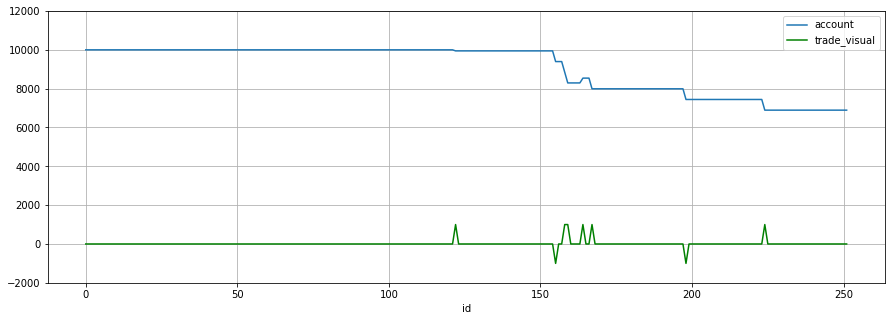

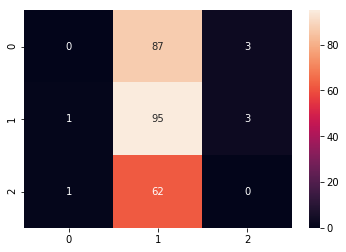

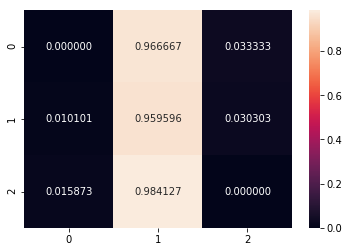

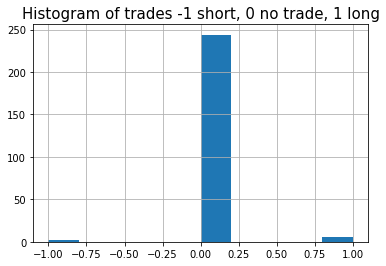

In [117]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300, name='coffee_nn_cls')

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [156]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [158]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [159]:
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1927 samples, validate on 484 samples
Epoch 1/1000
1927/1927 [==============================] - 4s 2ms/step - loss: 1279831.4820 - val_loss: 1215189.6501

Epoch 00001: val_loss improved from inf to 1215189.65005, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1927/1927 [==============================] - 0s 186us/step - loss: 1279829.6259 - val_loss: 1215190.6198

Epoch 00002: val_loss did not improve from 1215189.65005
Epoch 3/1000
1927/1927 [==============================] - 0s 185us/step - loss: 1279814.1279 - val_loss: 1215190.4285

Epoch 00003: val_loss did not improve from 1215189.65005
Epoch 4/1000
1927/1927 [==============================] - 0s 178us/step - loss: 1279819.3353 - val_loss: 1215190.7905

Epoch 00004: val_loss did not improve from 1215189.65005
Epoch 5/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1279810.9057 - val_loss: 1215190.8649

Epoch 00005: val_loss did not improve from 1215189.65005
Epoch 6/1000
1927/1927 

1927/1927 [==============================] - 0s 191us/step - loss: 1279390.1963 - val_loss: 1215143.2066

Epoch 00040: val_loss improved from 1215151.43337 to 1215143.20661, saving model to saved_models/weights.gold_reg.hdf5
Epoch 41/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1279417.7456 - val_loss: 1215134.9938

Epoch 00041: val_loss improved from 1215143.20661 to 1215134.99380, saving model to saved_models/weights.gold_reg.hdf5
Epoch 42/1000
1927/1927 [==============================] - 0s 185us/step - loss: 1279348.0388 - val_loss: 1215127.3053

Epoch 00042: val_loss improved from 1215134.99380 to 1215127.30527, saving model to saved_models/weights.gold_reg.hdf5
Epoch 43/1000
1927/1927 [==============================] - 0s 166us/step - loss: 1279253.0326 - val_loss: 1215120.1653

Epoch 00043: val_loss improved from 1215127.30527 to 1215120.16529, saving model to saved_models/weights.gold_reg.hdf5
Epoch 44/1000
1927/1927 [==============================] -

1927/1927 [==============================] - 0s 214us/step - loss: 1274565.3712 - val_loss: 1214598.4551

Epoch 00075: val_loss improved from 1214627.55759 to 1214598.45506, saving model to saved_models/weights.gold_reg.hdf5
Epoch 76/1000
1927/1927 [==============================] - 0s 202us/step - loss: 1274664.9388 - val_loss: 1214592.1622

Epoch 00076: val_loss improved from 1214598.45506 to 1214592.16219, saving model to saved_models/weights.gold_reg.hdf5
Epoch 77/1000
1927/1927 [==============================] - 0s 185us/step - loss: 1274462.6419 - val_loss: 1214628.9553

Epoch 00077: val_loss did not improve from 1214592.16219
Epoch 78/1000
1927/1927 [==============================] - 0s 178us/step - loss: 1274304.6626 - val_loss: 1214630.6142

Epoch 00078: val_loss did not improve from 1214592.16219
Epoch 79/1000
1927/1927 [==============================] - 0s 170us/step - loss: 1273951.0274 - val_loss: 1214592.8244

Epoch 00079: val_loss did not improve from 1214592.16219
Epoch

1927/1927 [==============================] - 0s 209us/step - loss: 1265102.6800 - val_loss: 1214377.7557

Epoch 00115: val_loss did not improve from 1214303.75387
Epoch 116/1000
1927/1927 [==============================] - 0s 194us/step - loss: 1264745.9447 - val_loss: 1214357.6968

Epoch 00116: val_loss did not improve from 1214303.75387
Epoch 117/1000
1927/1927 [==============================] - 0s 191us/step - loss: 1264438.3955 - val_loss: 1214303.2831

Epoch 00117: val_loss improved from 1214303.75387 to 1214303.28306, saving model to saved_models/weights.gold_reg.hdf5
Epoch 118/1000
1927/1927 [==============================] - 0s 196us/step - loss: 1264171.7608 - val_loss: 1214227.3993

Epoch 00118: val_loss improved from 1214303.28306 to 1214227.39928, saving model to saved_models/weights.gold_reg.hdf5
Epoch 119/1000
1927/1927 [==============================] - 0s 176us/step - loss: 1263517.3619 - val_loss: 1214199.0754

Epoch 00119: val_loss improved from 1214227.39928 to 12141

1927/1927 [==============================] - 0s 186us/step - loss: 1252852.5134 - val_loss: 1213692.2327

Epoch 00156: val_loss improved from 1213743.01601 to 1213692.23270, saving model to saved_models/weights.gold_reg.hdf5
Epoch 157/1000
1927/1927 [==============================] - 0s 174us/step - loss: 1252179.2390 - val_loss: 1213690.4140

Epoch 00157: val_loss improved from 1213692.23270 to 1213690.41400, saving model to saved_models/weights.gold_reg.hdf5
Epoch 158/1000
1927/1927 [==============================] - 0s 192us/step - loss: 1252689.1098 - val_loss: 1213683.4938

Epoch 00158: val_loss improved from 1213690.41400 to 1213683.49380, saving model to saved_models/weights.gold_reg.hdf5
Epoch 159/1000
1927/1927 [==============================] - 0s 189us/step - loss: 1251066.4584 - val_loss: 1213736.1201

Epoch 00159: val_loss did not improve from 1213683.49380
Epoch 160/1000
1927/1927 [==============================] - 0s 177us/step - loss: 1250849.5185 - val_loss: 1213705.02

1927/1927 [==============================] - 0s 182us/step - loss: 1236403.5997 - val_loss: 1213521.4264

Epoch 00200: val_loss did not improve from 1213471.24122
Epoch 201/1000
1927/1927 [==============================] - 0s 183us/step - loss: 1234802.5565 - val_loss: 1213486.4137

Epoch 00201: val_loss did not improve from 1213471.24122
Epoch 202/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1235784.3502 - val_loss: 1213514.8244

Epoch 00202: val_loss did not improve from 1213471.24122
Epoch 203/1000
1927/1927 [==============================] - 0s 185us/step - loss: 1234629.2256 - val_loss: 1213528.6198

Epoch 00203: val_loss did not improve from 1213471.24122
Epoch 204/1000
1927/1927 [==============================] - 0s 184us/step - loss: 1235503.0791 - val_loss: 1213505.7872

Epoch 00204: val_loss did not improve from 1213471.24122
Epoch 205/1000
1927/1927 [==============================] - 0s 176us/step - loss: 1235179.0377 - val_loss: 1213416.4561

Epoc

1927/1927 [==============================] - 0s 178us/step - loss: 1218922.5736 - val_loss: 1212773.4442

Epoch 00240: val_loss did not improve from 1212372.57515
Epoch 241/1000
1927/1927 [==============================] - 0s 188us/step - loss: 1219325.9153 - val_loss: 1212810.7998

Epoch 00241: val_loss did not improve from 1212372.57515
Epoch 242/1000
1927/1927 [==============================] - 0s 167us/step - loss: 1218048.3539 - val_loss: 1212746.9104

Epoch 00242: val_loss did not improve from 1212372.57515
Epoch 243/1000
1927/1927 [==============================] - 0s 169us/step - loss: 1217392.5880 - val_loss: 1212783.1555

Epoch 00243: val_loss did not improve from 1212372.57515
Epoch 244/1000
1927/1927 [==============================] - 0s 169us/step - loss: 1215413.5163 - val_loss: 1212615.7035

Epoch 00244: val_loss did not improve from 1212372.57515
Epoch 245/1000
1927/1927 [==============================] - 0s 169us/step - loss: 1216349.7884 - val_loss: 1212521.5894

Epoc

1927/1927 [==============================] - 0s 183us/step - loss: 1197733.5925 - val_loss: 1212106.3104

Epoch 00285: val_loss improved from 1212108.85434 to 1212106.31043, saving model to saved_models/weights.gold_reg.hdf5
Epoch 286/1000
1927/1927 [==============================] - 0s 169us/step - loss: 1197021.8608 - val_loss: 1211873.6865

Epoch 00286: val_loss improved from 1212106.31043 to 1211873.68647, saving model to saved_models/weights.gold_reg.hdf5
Epoch 287/1000
1927/1927 [==============================] - 0s 165us/step - loss: 1194049.5982 - val_loss: 1211864.6224

Epoch 00287: val_loss improved from 1211873.68647 to 1211864.62242, saving model to saved_models/weights.gold_reg.hdf5
Epoch 288/1000
1927/1927 [==============================] - 0s 162us/step - loss: 1192970.6624 - val_loss: 1211979.0411

Epoch 00288: val_loss did not improve from 1211864.62242
Epoch 289/1000
1927/1927 [==============================] - 0s 162us/step - loss: 1195729.1740 - val_loss: 1211882.82


Epoch 00328: val_loss did not improve from 1211593.05036
Epoch 329/1000
1927/1927 [==============================] - 0s 183us/step - loss: 1173772.7655 - val_loss: 1212166.8877

Epoch 00329: val_loss did not improve from 1211593.05036
Epoch 330/1000
1927/1927 [==============================] - 0s 185us/step - loss: 1173735.9403 - val_loss: 1212140.8463

Epoch 00330: val_loss did not improve from 1211593.05036
Epoch 331/1000
1927/1927 [==============================] - 0s 183us/step - loss: 1171521.6480 - val_loss: 1212332.0963

Epoch 00331: val_loss did not improve from 1211593.05036
Epoch 332/1000
1927/1927 [==============================] - 0s 186us/step - loss: 1171806.7445 - val_loss: 1212374.3840

Epoch 00332: val_loss did not improve from 1211593.05036
Epoch 333/1000
1927/1927 [==============================] - 0s 179us/step - loss: 1171505.4987 - val_loss: 1212293.9744

Epoch 00333: val_loss did not improve from 1211593.05036
Epoch 334/1000
1927/1927 [==========================

1927/1927 [==============================] - 0s 206us/step - loss: 1144280.8935 - val_loss: 1211664.2658

Epoch 00374: val_loss did not improve from 1211511.57722
Epoch 375/1000
1927/1927 [==============================] - 0s 180us/step - loss: 1146340.7508 - val_loss: 1211708.6689

Epoch 00375: val_loss did not improve from 1211511.57722
Epoch 376/1000
1927/1927 [==============================] - 0s 165us/step - loss: 1144890.0797 - val_loss: 1211745.1921

Epoch 00376: val_loss did not improve from 1211511.57722
Epoch 377/1000
1927/1927 [==============================] - 0s 172us/step - loss: 1148475.7263 - val_loss: 1211708.0150

Epoch 00377: val_loss did not improve from 1211511.57722
Epoch 378/1000
1927/1927 [==============================] - 0s 166us/step - loss: 1142621.7385 - val_loss: 1211836.7350

Epoch 00378: val_loss did not improve from 1211511.57722
Epoch 379/1000
1927/1927 [==============================] - 0s 177us/step - loss: 1140684.6526 - val_loss: 1211790.8559

Epoc

1927/1927 [==============================] - 0s 181us/step - loss: 1117240.3193 - val_loss: 1212648.8210

Epoch 00420: val_loss did not improve from 1211511.57722
Epoch 421/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1114659.3303 - val_loss: 1212777.3959

Epoch 00421: val_loss did not improve from 1211511.57722
Epoch 422/1000
1927/1927 [==============================] - 0s 195us/step - loss: 1115937.9326 - val_loss: 1212811.7562

Epoch 00422: val_loss did not improve from 1211511.57722
Epoch 423/1000
1927/1927 [==============================] - 0s 175us/step - loss: 1116760.4694 - val_loss: 1213013.4713

Epoch 00423: val_loss did not improve from 1211511.57722
Epoch 424/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1113739.9450 - val_loss: 1213071.6684

Epoch 00424: val_loss did not improve from 1211511.57722
Epoch 425/1000
1927/1927 [==============================] - 0s 170us/step - loss: 1111534.3506 - val_loss: 1212937.1402

Epoc

1927/1927 [==============================] - 0s 175us/step - loss: 1088229.2658 - val_loss: 1213358.3786

Epoch 00466: val_loss did not improve from 1211511.57722
Epoch 467/1000
1927/1927 [==============================] - 0s 176us/step - loss: 1088058.4469 - val_loss: 1213137.2541

Epoch 00467: val_loss did not improve from 1211511.57722
Epoch 468/1000
1927/1927 [==============================] - 0s 165us/step - loss: 1085452.4014 - val_loss: 1213202.3014

Epoch 00468: val_loss did not improve from 1211511.57722
Epoch 469/1000
1927/1927 [==============================] - 0s 178us/step - loss: 1086399.9585 - val_loss: 1213258.5917

Epoch 00469: val_loss did not improve from 1211511.57722
Epoch 470/1000
1927/1927 [==============================] - 0s 181us/step - loss: 1083740.5381 - val_loss: 1213570.0271

Epoch 00470: val_loss did not improve from 1211511.57722
Epoch 471/1000
1927/1927 [==============================] - 0s 175us/step - loss: 1082364.8304 - val_loss: 1213296.0857

Epoc

1927/1927 [==============================] - 0s 196us/step - loss: 1049498.0148 - val_loss: 1214267.8319

Epoch 00512: val_loss did not improve from 1211511.57722
Epoch 513/1000
1927/1927 [==============================] - 0s 203us/step - loss: 1051595.7372 - val_loss: 1214684.8525

Epoch 00513: val_loss did not improve from 1211511.57722
Epoch 514/1000
1927/1927 [==============================] - 0s 168us/step - loss: 1048589.3357 - val_loss: 1214703.6816

Epoch 00514: val_loss did not improve from 1211511.57722
Epoch 515/1000
1927/1927 [==============================] - 0s 164us/step - loss: 1047749.5402 - val_loss: 1214869.4478

Epoch 00515: val_loss did not improve from 1211511.57722
Epoch 516/1000
1927/1927 [==============================] - 0s 166us/step - loss: 1053180.2085 - val_loss: 1215061.6470

Epoch 00516: val_loss did not improve from 1211511.57722
Epoch 517/1000
1927/1927 [==============================] - 0s 161us/step - loss: 1053181.6178 - val_loss: 1215065.3048

Epoc

1927/1927 [==============================] - 0s 235us/step - loss: 1019917.7741 - val_loss: 1217809.0945

Epoch 00558: val_loss did not improve from 1211511.57722
Epoch 559/1000
1927/1927 [==============================] - 0s 207us/step - loss: 1020879.8723 - val_loss: 1217402.0256

Epoch 00559: val_loss did not improve from 1211511.57722
Epoch 560/1000
1927/1927 [==============================] - 0s 171us/step - loss: 1015263.7139 - val_loss: 1217295.6710

Epoch 00560: val_loss did not improve from 1211511.57722
Epoch 561/1000
1927/1927 [==============================] - 0s 163us/step - loss: 1015578.8601 - val_loss: 1216778.7505

Epoch 00561: val_loss did not improve from 1211511.57722
Epoch 562/1000
1927/1927 [==============================] - 0s 173us/step - loss: 1019154.4055 - val_loss: 1216450.9476

Epoch 00562: val_loss did not improve from 1211511.57722
Epoch 563/1000
1927/1927 [==============================] - 0s 179us/step - loss: 1010450.6266 - val_loss: 1216123.7058

Epoc

1927/1927 [==============================] - 0s 167us/step - loss: 986628.5463 - val_loss: 1220907.1769

Epoch 00604: val_loss did not improve from 1211511.57722
Epoch 605/1000
1927/1927 [==============================] - 0s 179us/step - loss: 979841.4775 - val_loss: 1221341.5987

Epoch 00605: val_loss did not improve from 1211511.57722
Epoch 606/1000
1927/1927 [==============================] - 0s 166us/step - loss: 977709.9451 - val_loss: 1221225.0310

Epoch 00606: val_loss did not improve from 1211511.57722
Epoch 607/1000
1927/1927 [==============================] - 0s 164us/step - loss: 983456.7902 - val_loss: 1221094.8569

Epoch 00607: val_loss did not improve from 1211511.57722
Epoch 608/1000
1927/1927 [==============================] - 0s 164us/step - loss: 978076.9290 - val_loss: 1221011.4362

Epoch 00608: val_loss did not improve from 1211511.57722
Epoch 609/1000
1927/1927 [==============================] - 0s 168us/step - loss: 982435.9633 - val_loss: 1221163.6333

Epoch 0060

1927/1927 [==============================] - 0s 203us/step - loss: 944620.8543 - val_loss: 1225180.6351

Epoch 00650: val_loss did not improve from 1211511.57722
Epoch 651/1000
1927/1927 [==============================] - 0s 191us/step - loss: 945013.6403 - val_loss: 1225465.2265

Epoch 00651: val_loss did not improve from 1211511.57722
Epoch 652/1000
1927/1927 [==============================] - 0s 178us/step - loss: 948900.9323 - val_loss: 1225873.0987

Epoch 00652: val_loss did not improve from 1211511.57722
Epoch 653/1000
1927/1927 [==============================] - 0s 185us/step - loss: 941871.7264 - val_loss: 1225885.0230

Epoch 00653: val_loss did not improve from 1211511.57722
Epoch 654/1000
1927/1927 [==============================] - 0s 187us/step - loss: 944907.1686 - val_loss: 1226450.9308

Epoch 00654: val_loss did not improve from 1211511.57722
Epoch 655/1000
1927/1927 [==============================] - 0s 195us/step - loss: 948182.0591 - val_loss: 1227028.2373

Epoch 0065

1927/1927 [==============================] - 1s 273us/step - loss: 906302.3665 - val_loss: 1230629.0749

Epoch 00696: val_loss did not improve from 1211511.57722
Epoch 697/1000
1927/1927 [==============================] - 0s 219us/step - loss: 904985.0494 - val_loss: 1230201.4605

Epoch 00697: val_loss did not improve from 1211511.57722
Epoch 698/1000
1927/1927 [==============================] - 0s 198us/step - loss: 908702.6545 - val_loss: 1230577.2510

Epoch 00698: val_loss did not improve from 1211511.57722
Epoch 699/1000
1927/1927 [==============================] - 0s 197us/step - loss: 907716.2588 - val_loss: 1231180.1692

Epoch 00699: val_loss did not improve from 1211511.57722
Epoch 700/1000
1927/1927 [==============================] - 0s 192us/step - loss: 901456.1585 - val_loss: 1231009.3148

Epoch 00700: val_loss did not improve from 1211511.57722
Epoch 701/1000
1927/1927 [==============================] - 0s 208us/step - loss: 899439.1335 - val_loss: 1231060.7965

Epoch 0070

1927/1927 [==============================] - 0s 176us/step - loss: 867797.0322 - val_loss: 1237707.3419

Epoch 00742: val_loss did not improve from 1211511.57722
Epoch 743/1000
1927/1927 [==============================] - 0s 177us/step - loss: 871317.7355 - val_loss: 1237285.9318

Epoch 00743: val_loss did not improve from 1211511.57722
Epoch 744/1000
1927/1927 [==============================] - 0s 191us/step - loss: 868142.5240 - val_loss: 1238218.2683

Epoch 00744: val_loss did not improve from 1211511.57722
Epoch 745/1000
1927/1927 [==============================] - 0s 175us/step - loss: 865090.4928 - val_loss: 1237295.0457

Epoch 00745: val_loss did not improve from 1211511.57722
Epoch 746/1000
1927/1927 [==============================] - 0s 170us/step - loss: 865185.8939 - val_loss: 1237334.0287

Epoch 00746: val_loss did not improve from 1211511.57722
Epoch 747/1000
1927/1927 [==============================] - 0s 176us/step - loss: 863013.8012 - val_loss: 1237138.8200

Epoch 0074

1927/1927 [==============================] - 0s 197us/step - loss: 833606.0715 - val_loss: 1243061.8195

Epoch 00788: val_loss did not improve from 1211511.57722
Epoch 789/1000
1927/1927 [==============================] - 0s 177us/step - loss: 820193.7353 - val_loss: 1243266.6550

Epoch 00789: val_loss did not improve from 1211511.57722
Epoch 790/1000
1927/1927 [==============================] - 0s 170us/step - loss: 830808.6617 - val_loss: 1245254.1028

Epoch 00790: val_loss did not improve from 1211511.57722
Epoch 791/1000
1927/1927 [==============================] - 0s 166us/step - loss: 831336.2802 - val_loss: 1244761.8001

Epoch 00791: val_loss did not improve from 1211511.57722
Epoch 792/1000
1927/1927 [==============================] - 0s 168us/step - loss: 828238.2960 - val_loss: 1245192.9855

Epoch 00792: val_loss did not improve from 1211511.57722
Epoch 793/1000
1927/1927 [==============================] - 0s 169us/step - loss: 832413.1745 - val_loss: 1245094.2221

Epoch 0079

1927/1927 [==============================] - 0s 169us/step - loss: 789267.7662 - val_loss: 1254199.3745

Epoch 00834: val_loss did not improve from 1211511.57722
Epoch 835/1000
1927/1927 [==============================] - 0s 173us/step - loss: 792092.7655 - val_loss: 1254542.1395

Epoch 00835: val_loss did not improve from 1211511.57722
Epoch 836/1000
1927/1927 [==============================] - 0s 166us/step - loss: 793036.3656 - val_loss: 1254641.4871

Epoch 00836: val_loss did not improve from 1211511.57722
Epoch 837/1000
1927/1927 [==============================] - 0s 172us/step - loss: 781391.5533 - val_loss: 1254866.0938

Epoch 00837: val_loss did not improve from 1211511.57722
Epoch 838/1000
1927/1927 [==============================] - 0s 171us/step - loss: 792666.0254 - val_loss: 1255591.5036

Epoch 00838: val_loss did not improve from 1211511.57722
Epoch 839/1000
1927/1927 [==============================] - 0s 167us/step - loss: 798290.9171 - val_loss: 1255995.6761

Epoch 0083

1927/1927 [==============================] - 0s 179us/step - loss: 753646.3563 - val_loss: 1266295.9837

Epoch 00880: val_loss did not improve from 1211511.57722
Epoch 881/1000
1927/1927 [==============================] - 0s 175us/step - loss: 749936.5534 - val_loss: 1266661.5930

Epoch 00881: val_loss did not improve from 1211511.57722
Epoch 882/1000
1927/1927 [==============================] - 0s 172us/step - loss: 746062.8469 - val_loss: 1267628.1681

Epoch 00882: val_loss did not improve from 1211511.57722
Epoch 883/1000
1927/1927 [==============================] - 0s 170us/step - loss: 745591.9271 - val_loss: 1267379.3693

Epoch 00883: val_loss did not improve from 1211511.57722
Epoch 884/1000
1927/1927 [==============================] - 0s 172us/step - loss: 743900.2046 - val_loss: 1266790.4920

Epoch 00884: val_loss did not improve from 1211511.57722
Epoch 885/1000
1927/1927 [==============================] - 0s 167us/step - loss: 740610.5131 - val_loss: 1268278.5958

Epoch 0088

1927/1927 [==============================] - 0s 173us/step - loss: 715649.6791 - val_loss: 1276777.6232

Epoch 00926: val_loss did not improve from 1211511.57722
Epoch 927/1000
1927/1927 [==============================] - 0s 174us/step - loss: 711156.1893 - val_loss: 1277578.7627

Epoch 00927: val_loss did not improve from 1211511.57722
Epoch 928/1000
1927/1927 [==============================] - 0s 180us/step - loss: 705698.9799 - val_loss: 1278393.0829

Epoch 00928: val_loss did not improve from 1211511.57722
Epoch 929/1000
1927/1927 [==============================] - 0s 177us/step - loss: 704904.1035 - val_loss: 1278817.0850

Epoch 00929: val_loss did not improve from 1211511.57722
Epoch 930/1000
1927/1927 [==============================] - 0s 187us/step - loss: 700021.2464 - val_loss: 1279884.8817

Epoch 00930: val_loss did not improve from 1211511.57722
Epoch 931/1000
1927/1927 [==============================] - 0s 183us/step - loss: 716023.6845 - val_loss: 1279178.4657

Epoch 0093

1927/1927 [==============================] - 0s 190us/step - loss: 683043.7823 - val_loss: 1292780.8864

Epoch 00972: val_loss did not improve from 1211511.57722
Epoch 973/1000
1927/1927 [==============================] - 0s 178us/step - loss: 675903.7738 - val_loss: 1294717.6650

Epoch 00973: val_loss did not improve from 1211511.57722
Epoch 974/1000
1927/1927 [==============================] - 0s 179us/step - loss: 670717.1864 - val_loss: 1295290.1870

Epoch 00974: val_loss did not improve from 1211511.57722
Epoch 975/1000
1927/1927 [==============================] - 0s 170us/step - loss: 672181.2676 - val_loss: 1297118.0542

Epoch 00975: val_loss did not improve from 1211511.57722
Epoch 976/1000
1927/1927 [==============================] - 0s 174us/step - loss: 674788.0557 - val_loss: 1298311.4845

Epoch 00976: val_loss did not improve from 1211511.57722
Epoch 977/1000
1927/1927 [==============================] - 0s 171us/step - loss: 657828.6280 - val_loss: 1296010.1320

Epoch 0097

In [160]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.12017141545960527
Returns  171.23 %
Number of trades:  126
Number of short trades:  33
Number of long trades:  93
Earnings per trade:  135.90
Earnings per short trade:  284.26
Earnings per long trade:  83.25
Precision score:  [0.63636364 0.00793651 0.50537634]


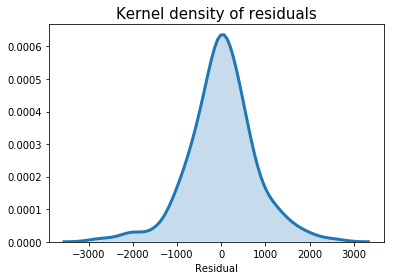

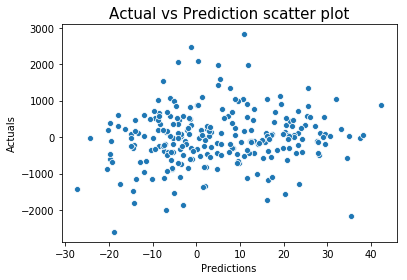

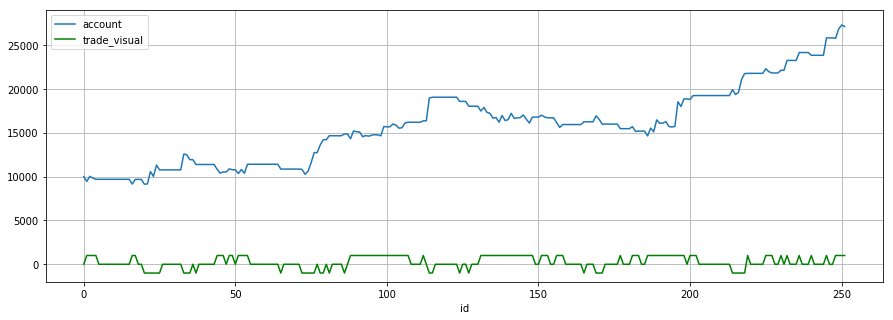

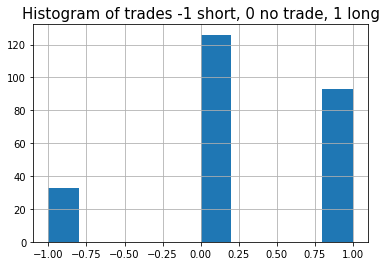

In [162]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_nn_reg')

In [163]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1928 samples, validate on 483 samples
Epoch 1/1000
1928/1928 [==============================] - 5s 3ms/step - loss: 132373.5754 - val_loss: 131889.6627

Epoch 00001: val_loss improved from inf to 131889.66272, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1928/1928 [==============================] - 0s 182us/step - loss: 132376.4345 - val_loss: 131889.9246

Epoch 00002: val_loss did not improve from 131889.66272
Epoch 3/1000
1928/1928 [==============================] - 0s 170us/step - loss: 132364.5236 - val_loss: 131890.9430

Epoch 00003: val_loss did not improve from 131889.66272
Epoch 4/1000
1928/1928 [==============================] - 0s 199us/step - loss: 132361.3429 - val_loss: 131891.5228

Epoch 00004: val_loss did not improve from 131889.66272
Epoch 5/1000
1928/1928 [==============================] - 0s 171us/step - loss: 132360.3210 - val_loss: 131892.3978

Epoch 00005: val_loss did not improve from 131889.66272
Epoch 6/1000
1928/1928 [==============


Epoch 00047: val_loss did not improve from 131889.66272
Epoch 48/1000
1928/1928 [==============================] - 0s 199us/step - loss: 131239.8646 - val_loss: 131996.1599

Epoch 00048: val_loss did not improve from 131889.66272
Epoch 49/1000
1928/1928 [==============================] - 0s 200us/step - loss: 131068.2417 - val_loss: 131989.5916

Epoch 00049: val_loss did not improve from 131889.66272
Epoch 50/1000
1928/1928 [==============================] - 0s 226us/step - loss: 131067.3514 - val_loss: 132003.9678

Epoch 00050: val_loss did not improve from 131889.66272
Epoch 51/1000
1928/1928 [==============================] - 0s 191us/step - loss: 131016.6063 - val_loss: 132006.1870

Epoch 00051: val_loss did not improve from 131889.66272
Epoch 52/1000
1928/1928 [==============================] - 0s 191us/step - loss: 131000.6140 - val_loss: 132008.0727

Epoch 00052: val_loss did not improve from 131889.66272
Epoch 53/1000
1928/1928 [==============================] - 0s 202us/step 


Epoch 00094: val_loss did not improve from 131889.66272
Epoch 95/1000
1928/1928 [==============================] - 0s 181us/step - loss: 127464.1221 - val_loss: 132150.1352

Epoch 00095: val_loss did not improve from 131889.66272
Epoch 96/1000
1928/1928 [==============================] - 0s 184us/step - loss: 127326.6423 - val_loss: 132176.3597

Epoch 00096: val_loss did not improve from 131889.66272
Epoch 97/1000
1928/1928 [==============================] - 0s 190us/step - loss: 127173.6847 - val_loss: 132184.7739

Epoch 00097: val_loss did not improve from 131889.66272
Epoch 98/1000
1928/1928 [==============================] - 0s 199us/step - loss: 127147.9725 - val_loss: 132173.4543

Epoch 00098: val_loss did not improve from 131889.66272
Epoch 99/1000
1928/1928 [==============================] - 0s 188us/step - loss: 127050.3110 - val_loss: 132153.4898

Epoch 00099: val_loss did not improve from 131889.66272
Epoch 100/1000
1928/1928 [==============================] - 0s 241us/step


Epoch 00141: val_loss did not improve from 131889.66272
Epoch 142/1000
1928/1928 [==============================] - 0s 166us/step - loss: 122893.2353 - val_loss: 132357.3999

Epoch 00142: val_loss did not improve from 131889.66272
Epoch 143/1000
1928/1928 [==============================] - 0s 168us/step - loss: 122596.7000 - val_loss: 132357.9719

Epoch 00143: val_loss did not improve from 131889.66272
Epoch 144/1000
1928/1928 [==============================] - 0s 163us/step - loss: 122550.6993 - val_loss: 132334.3891

Epoch 00144: val_loss did not improve from 131889.66272
Epoch 145/1000
1928/1928 [==============================] - 0s 163us/step - loss: 122758.2802 - val_loss: 132325.4842

Epoch 00145: val_loss did not improve from 131889.66272
Epoch 146/1000
1928/1928 [==============================] - 0s 167us/step - loss: 122561.2503 - val_loss: 132379.0006

Epoch 00146: val_loss did not improve from 131889.66272
Epoch 147/1000
1928/1928 [==============================] - 0s 173us

1928/1928 [==============================] - 0s 171us/step - loss: 117327.8868 - val_loss: 132688.2344

Epoch 00188: val_loss did not improve from 131889.66272
Epoch 189/1000
1928/1928 [==============================] - 0s 159us/step - loss: 117598.0502 - val_loss: 132718.4497

Epoch 00189: val_loss did not improve from 131889.66272
Epoch 190/1000
1928/1928 [==============================] - 0s 176us/step - loss: 117080.1452 - val_loss: 132681.8999

Epoch 00190: val_loss did not improve from 131889.66272
Epoch 191/1000
1928/1928 [==============================] - 0s 171us/step - loss: 117152.1663 - val_loss: 132711.0449

Epoch 00191: val_loss did not improve from 131889.66272
Epoch 192/1000
1928/1928 [==============================] - 0s 185us/step - loss: 116971.3233 - val_loss: 132728.7231

Epoch 00192: val_loss did not improve from 131889.66272
Epoch 193/1000
1928/1928 [==============================] - 0s 188us/step - loss: 116871.9227 - val_loss: 132717.9764

Epoch 00193: val_loss

1928/1928 [==============================] - 0s 171us/step - loss: 110465.6587 - val_loss: 133193.7708

Epoch 00235: val_loss did not improve from 131889.66272
Epoch 236/1000
1928/1928 [==============================] - 0s 169us/step - loss: 111104.1933 - val_loss: 133288.5035

Epoch 00236: val_loss did not improve from 131889.66272
Epoch 237/1000
1928/1928 [==============================] - 0s 178us/step - loss: 110331.7287 - val_loss: 133309.2626

Epoch 00237: val_loss did not improve from 131889.66272
Epoch 238/1000
1928/1928 [==============================] - 0s 169us/step - loss: 110680.7962 - val_loss: 133398.7681

Epoch 00238: val_loss did not improve from 131889.66272
Epoch 239/1000
1928/1928 [==============================] - 0s 163us/step - loss: 110626.5230 - val_loss: 133415.7400

Epoch 00239: val_loss did not improve from 131889.66272
Epoch 240/1000
1928/1928 [==============================] - 0s 178us/step - loss: 109571.2115 - val_loss: 133451.1137

Epoch 00240: val_loss

1928/1928 [==============================] - 0s 162us/step - loss: 103850.5366 - val_loss: 133987.1894

Epoch 00282: val_loss did not improve from 131889.66272
Epoch 283/1000
1928/1928 [==============================] - 0s 161us/step - loss: 104103.6074 - val_loss: 133893.9663

Epoch 00283: val_loss did not improve from 131889.66272
Epoch 284/1000
1928/1928 [==============================] - 0s 170us/step - loss: 103572.1023 - val_loss: 133941.8961

Epoch 00284: val_loss did not improve from 131889.66272
Epoch 285/1000
1928/1928 [==============================] - 0s 164us/step - loss: 103120.3181 - val_loss: 133895.1593

Epoch 00285: val_loss did not improve from 131889.66272
Epoch 286/1000
1928/1928 [==============================] - 0s 164us/step - loss: 103259.1280 - val_loss: 133868.6514

Epoch 00286: val_loss did not improve from 131889.66272
Epoch 287/1000
1928/1928 [==============================] - 0s 164us/step - loss: 103217.2328 - val_loss: 133992.9867

Epoch 00287: val_loss

1928/1928 [==============================] - 0s 165us/step - loss: 96369.5114 - val_loss: 135140.7329

Epoch 00329: val_loss did not improve from 131889.66272
Epoch 330/1000
1928/1928 [==============================] - 0s 166us/step - loss: 95944.1286 - val_loss: 135127.3222

Epoch 00330: val_loss did not improve from 131889.66272
Epoch 331/1000
1928/1928 [==============================] - 0s 161us/step - loss: 96655.8273 - val_loss: 135162.0577

Epoch 00331: val_loss did not improve from 131889.66272
Epoch 332/1000
1928/1928 [==============================] - 0s 173us/step - loss: 96681.0038 - val_loss: 135303.4063

Epoch 00332: val_loss did not improve from 131889.66272
Epoch 333/1000
1928/1928 [==============================] - 0s 196us/step - loss: 95412.9989 - val_loss: 135388.4520

Epoch 00333: val_loss did not improve from 131889.66272
Epoch 334/1000
1928/1928 [==============================] - 0s 172us/step - loss: 95691.7833 - val_loss: 135406.4415

Epoch 00334: val_loss did n

1928/1928 [==============================] - 0s 174us/step - loss: 88343.2883 - val_loss: 136620.5903

Epoch 00376: val_loss did not improve from 131889.66272
Epoch 377/1000
1928/1928 [==============================] - 0s 167us/step - loss: 89013.0856 - val_loss: 136739.8860

Epoch 00377: val_loss did not improve from 131889.66272
Epoch 378/1000
1928/1928 [==============================] - 0s 193us/step - loss: 88260.7797 - val_loss: 136652.5581

Epoch 00378: val_loss did not improve from 131889.66272
Epoch 379/1000
1928/1928 [==============================] - 0s 170us/step - loss: 88914.7527 - val_loss: 136566.1020

Epoch 00379: val_loss did not improve from 131889.66272
Epoch 380/1000
1928/1928 [==============================] - 0s 159us/step - loss: 88772.0079 - val_loss: 136634.8114

Epoch 00380: val_loss did not improve from 131889.66272
Epoch 381/1000
1928/1928 [==============================] - 0s 176us/step - loss: 88544.4869 - val_loss: 136662.6580

Epoch 00381: val_loss did n

1928/1928 [==============================] - 0s 172us/step - loss: 81466.4610 - val_loss: 138175.8565

Epoch 00423: val_loss did not improve from 131889.66272
Epoch 424/1000
1928/1928 [==============================] - 0s 164us/step - loss: 81025.9970 - val_loss: 138421.3923

Epoch 00424: val_loss did not improve from 131889.66272
Epoch 425/1000
1928/1928 [==============================] - 0s 169us/step - loss: 82031.8908 - val_loss: 138566.1048

Epoch 00425: val_loss did not improve from 131889.66272
Epoch 426/1000
1928/1928 [==============================] - 0s 165us/step - loss: 81176.0568 - val_loss: 138545.8286

Epoch 00426: val_loss did not improve from 131889.66272
Epoch 427/1000
1928/1928 [==============================] - 0s 172us/step - loss: 80465.0410 - val_loss: 138606.1603

Epoch 00427: val_loss did not improve from 131889.66272
Epoch 428/1000
1928/1928 [==============================] - 0s 181us/step - loss: 81748.7577 - val_loss: 138387.0253

Epoch 00428: val_loss did n

1928/1928 [==============================] - 0s 215us/step - loss: 74205.4136 - val_loss: 140935.7599

Epoch 00470: val_loss did not improve from 131889.66272
Epoch 471/1000
1928/1928 [==============================] - 0s 177us/step - loss: 74357.9160 - val_loss: 141159.2620

Epoch 00471: val_loss did not improve from 131889.66272
Epoch 472/1000
1928/1928 [==============================] - 0s 196us/step - loss: 73705.7492 - val_loss: 141276.5319

Epoch 00472: val_loss did not improve from 131889.66272
Epoch 473/1000
1928/1928 [==============================] - 0s 214us/step - loss: 73639.3824 - val_loss: 141229.0788

Epoch 00473: val_loss did not improve from 131889.66272
Epoch 474/1000
1928/1928 [==============================] - 0s 217us/step - loss: 72725.4399 - val_loss: 141076.5980

Epoch 00474: val_loss did not improve from 131889.66272
Epoch 475/1000
1928/1928 [==============================] - 0s 202us/step - loss: 72847.3303 - val_loss: 141326.8801

Epoch 00475: val_loss did n

1928/1928 [==============================] - 0s 172us/step - loss: 66928.4360 - val_loss: 144187.3706

Epoch 00517: val_loss did not improve from 131889.66272
Epoch 518/1000
1928/1928 [==============================] - 0s 176us/step - loss: 67057.4151 - val_loss: 144504.6173

Epoch 00518: val_loss did not improve from 131889.66272
Epoch 519/1000
1928/1928 [==============================] - 0s 174us/step - loss: 66348.9158 - val_loss: 144378.2590

Epoch 00519: val_loss did not improve from 131889.66272
Epoch 520/1000
1928/1928 [==============================] - 0s 173us/step - loss: 66640.3401 - val_loss: 144343.5178

Epoch 00520: val_loss did not improve from 131889.66272
Epoch 521/1000
1928/1928 [==============================] - 0s 172us/step - loss: 65689.4998 - val_loss: 144280.8605

Epoch 00521: val_loss did not improve from 131889.66272
Epoch 522/1000
1928/1928 [==============================] - 0s 167us/step - loss: 66125.0955 - val_loss: 144574.3992

Epoch 00522: val_loss did n

1928/1928 [==============================] - 0s 211us/step - loss: 58553.8567 - val_loss: 148018.5758

Epoch 00564: val_loss did not improve from 131889.66272
Epoch 565/1000
1928/1928 [==============================] - 0s 193us/step - loss: 58341.9379 - val_loss: 148140.3886

Epoch 00565: val_loss did not improve from 131889.66272
Epoch 566/1000
1928/1928 [==============================] - 0s 197us/step - loss: 58403.5112 - val_loss: 148478.8575

Epoch 00566: val_loss did not improve from 131889.66272
Epoch 567/1000
1928/1928 [==============================] - 0s 182us/step - loss: 59947.7815 - val_loss: 148455.2411

Epoch 00567: val_loss did not improve from 131889.66272
Epoch 568/1000
1928/1928 [==============================] - 0s 178us/step - loss: 58099.1414 - val_loss: 148691.7206

Epoch 00568: val_loss did not improve from 131889.66272
Epoch 569/1000
1928/1928 [==============================] - 0s 184us/step - loss: 57754.7514 - val_loss: 148840.7431

Epoch 00569: val_loss did n

1928/1928 [==============================] - 0s 191us/step - loss: 50636.8403 - val_loss: 152554.2309

Epoch 00611: val_loss did not improve from 131889.66272
Epoch 612/1000
1928/1928 [==============================] - 0s 190us/step - loss: 51044.6911 - val_loss: 152306.9991

Epoch 00612: val_loss did not improve from 131889.66272
Epoch 613/1000
1928/1928 [==============================] - 0s 213us/step - loss: 52332.0264 - val_loss: 152376.9067

Epoch 00613: val_loss did not improve from 131889.66272
Epoch 614/1000
1928/1928 [==============================] - 0s 189us/step - loss: 52323.3895 - val_loss: 152730.8074

Epoch 00614: val_loss did not improve from 131889.66272
Epoch 615/1000
1928/1928 [==============================] - 0s 199us/step - loss: 53851.7135 - val_loss: 153301.1393

Epoch 00615: val_loss did not improve from 131889.66272
Epoch 616/1000
1928/1928 [==============================] - 0s 192us/step - loss: 52010.9742 - val_loss: 153580.1270

Epoch 00616: val_loss did n

1928/1928 [==============================] - 0s 222us/step - loss: 44635.9969 - val_loss: 157414.3292

Epoch 00658: val_loss did not improve from 131889.66272
Epoch 659/1000
1928/1928 [==============================] - 0s 211us/step - loss: 46552.5358 - val_loss: 157730.8522

Epoch 00659: val_loss did not improve from 131889.66272
Epoch 660/1000
1928/1928 [==============================] - 0s 212us/step - loss: 46171.0373 - val_loss: 157720.7934

Epoch 00660: val_loss did not improve from 131889.66272
Epoch 661/1000
1928/1928 [==============================] - 0s 229us/step - loss: 44557.1764 - val_loss: 157785.3489

Epoch 00661: val_loss did not improve from 131889.66272
Epoch 662/1000
1928/1928 [==============================] - 0s 207us/step - loss: 45210.8045 - val_loss: 157996.0505

Epoch 00662: val_loss did not improve from 131889.66272
Epoch 663/1000
1928/1928 [==============================] - 0s 240us/step - loss: 44276.3587 - val_loss: 158219.2118

Epoch 00663: val_loss did n

1928/1928 [==============================] - 0s 183us/step - loss: 41613.8576 - val_loss: 163833.8300

Epoch 00705: val_loss did not improve from 131889.66272
Epoch 706/1000
1928/1928 [==============================] - 0s 180us/step - loss: 39915.7946 - val_loss: 163224.7578

Epoch 00706: val_loss did not improve from 131889.66272
Epoch 707/1000
1928/1928 [==============================] - 0s 180us/step - loss: 39506.1657 - val_loss: 163079.9255

Epoch 00707: val_loss did not improve from 131889.66272
Epoch 708/1000
1928/1928 [==============================] - 0s 176us/step - loss: 40392.1695 - val_loss: 163687.3536

Epoch 00708: val_loss did not improve from 131889.66272
Epoch 709/1000
1928/1928 [==============================] - 0s 182us/step - loss: 39085.8388 - val_loss: 163837.6832

Epoch 00709: val_loss did not improve from 131889.66272
Epoch 710/1000
1928/1928 [==============================] - 0s 196us/step - loss: 41223.3450 - val_loss: 164267.3609

Epoch 00710: val_loss did n

1928/1928 [==============================] - 0s 165us/step - loss: 33297.7423 - val_loss: 170384.6941

Epoch 00752: val_loss did not improve from 131889.66272
Epoch 753/1000
1928/1928 [==============================] - 0s 175us/step - loss: 35479.8906 - val_loss: 170008.3586

Epoch 00753: val_loss did not improve from 131889.66272
Epoch 754/1000
1928/1928 [==============================] - 0s 172us/step - loss: 36390.7877 - val_loss: 169678.4366

Epoch 00754: val_loss did not improve from 131889.66272
Epoch 755/1000
1928/1928 [==============================] - 0s 175us/step - loss: 36062.7554 - val_loss: 170050.2183

Epoch 00755: val_loss did not improve from 131889.66272
Epoch 756/1000
1928/1928 [==============================] - 0s 183us/step - loss: 34105.8790 - val_loss: 170311.1351

Epoch 00756: val_loss did not improve from 131889.66272
Epoch 757/1000
1928/1928 [==============================] - 0s 198us/step - loss: 34810.7617 - val_loss: 170805.5276

Epoch 00757: val_loss did n

1928/1928 [==============================] - 0s 170us/step - loss: 34300.0841 - val_loss: 176651.2493

Epoch 00799: val_loss did not improve from 131889.66272
Epoch 800/1000
1928/1928 [==============================] - 0s 204us/step - loss: 32867.6095 - val_loss: 176982.2812

Epoch 00800: val_loss did not improve from 131889.66272
Epoch 801/1000
1928/1928 [==============================] - 0s 195us/step - loss: 32061.0438 - val_loss: 177447.1702

Epoch 00801: val_loss did not improve from 131889.66272
Epoch 802/1000
1928/1928 [==============================] - 0s 184us/step - loss: 32636.6516 - val_loss: 178255.9338

Epoch 00802: val_loss did not improve from 131889.66272
Epoch 803/1000
1928/1928 [==============================] - 0s 176us/step - loss: 32395.4241 - val_loss: 176691.4960

Epoch 00803: val_loss did not improve from 131889.66272
Epoch 804/1000
1928/1928 [==============================] - 0s 169us/step - loss: 35388.5993 - val_loss: 177252.8115

Epoch 00804: val_loss did n

1928/1928 [==============================] - 0s 204us/step - loss: 29487.0269 - val_loss: 185226.2605

Epoch 00846: val_loss did not improve from 131889.66272
Epoch 847/1000
1928/1928 [==============================] - 0s 241us/step - loss: 29904.6833 - val_loss: 184949.0426

Epoch 00847: val_loss did not improve from 131889.66272
Epoch 848/1000
1928/1928 [==============================] - 0s 194us/step - loss: 28072.3256 - val_loss: 184602.6121

Epoch 00848: val_loss did not improve from 131889.66272
Epoch 849/1000
1928/1928 [==============================] - 0s 202us/step - loss: 28335.3512 - val_loss: 184738.4613

Epoch 00849: val_loss did not improve from 131889.66272
Epoch 850/1000
1928/1928 [==============================] - 0s 194us/step - loss: 27929.5824 - val_loss: 185437.5326

Epoch 00850: val_loss did not improve from 131889.66272
Epoch 851/1000
1928/1928 [==============================] - 0s 180us/step - loss: 28934.9195 - val_loss: 184656.2330

Epoch 00851: val_loss did n

1928/1928 [==============================] - 0s 189us/step - loss: 25572.1027 - val_loss: 190073.5954

Epoch 00893: val_loss did not improve from 131889.66272
Epoch 894/1000
1928/1928 [==============================] - 0s 207us/step - loss: 25994.1726 - val_loss: 189832.2668

Epoch 00894: val_loss did not improve from 131889.66272
Epoch 895/1000
1928/1928 [==============================] - 0s 192us/step - loss: 27820.7400 - val_loss: 190397.5293

Epoch 00895: val_loss did not improve from 131889.66272
Epoch 896/1000
1928/1928 [==============================] - 0s 190us/step - loss: 24482.2846 - val_loss: 189947.2908

Epoch 00896: val_loss did not improve from 131889.66272
Epoch 897/1000
1928/1928 [==============================] - 0s 185us/step - loss: 25207.5937 - val_loss: 189799.1409

Epoch 00897: val_loss did not improve from 131889.66272
Epoch 898/1000
1928/1928 [==============================] - 0s 202us/step - loss: 27715.4039 - val_loss: 190218.4140

Epoch 00898: val_loss did n

1928/1928 [==============================] - 0s 172us/step - loss: 25316.5034 - val_loss: 195891.7070

Epoch 00940: val_loss did not improve from 131889.66272
Epoch 941/1000
1928/1928 [==============================] - 0s 166us/step - loss: 26753.4986 - val_loss: 195290.4662

Epoch 00941: val_loss did not improve from 131889.66272
Epoch 942/1000
1928/1928 [==============================] - 0s 172us/step - loss: 25720.2409 - val_loss: 195761.8492

Epoch 00942: val_loss did not improve from 131889.66272
Epoch 943/1000
1928/1928 [==============================] - 0s 178us/step - loss: 24261.6039 - val_loss: 196349.0242

Epoch 00943: val_loss did not improve from 131889.66272
Epoch 944/1000
1928/1928 [==============================] - 0s 172us/step - loss: 21792.5655 - val_loss: 196064.6331

Epoch 00944: val_loss did not improve from 131889.66272
Epoch 945/1000
1928/1928 [==============================] - 0s 173us/step - loss: 25406.0499 - val_loss: 196339.6915

Epoch 00945: val_loss did n

1928/1928 [==============================] - 0s 230us/step - loss: 25363.9757 - val_loss: 199797.7689

Epoch 00987: val_loss did not improve from 131889.66272
Epoch 988/1000
1928/1928 [==============================] - 0s 180us/step - loss: 24291.6734 - val_loss: 199442.2471

Epoch 00988: val_loss did not improve from 131889.66272
Epoch 989/1000
1928/1928 [==============================] - 0s 179us/step - loss: 24380.4000 - val_loss: 199734.6491

Epoch 00989: val_loss did not improve from 131889.66272
Epoch 990/1000
1928/1928 [==============================] - 0s 209us/step - loss: 26147.8340 - val_loss: 201045.6330

Epoch 00990: val_loss did not improve from 131889.66272
Epoch 991/1000
1928/1928 [==============================] - 0s 173us/step - loss: 22779.3934 - val_loss: 200937.3790

Epoch 00991: val_loss did not improve from 131889.66272
Epoch 992/1000
1928/1928 [==============================] - 0s 173us/step - loss: 22641.1790 - val_loss: 200777.0601

Epoch 00992: val_loss did n

In [164]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.03090810399527193
Returns  -6.18 %
Number of trades:  51
Number of short trades:  27
Number of long trades:  24
Earnings per trade:  -12.11
Earnings per short trade:  -63.32
Earnings per long trade:  45.51
Precision score:  [0.33333333 0.04477612 0.70833333]


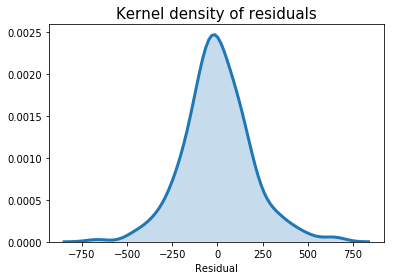

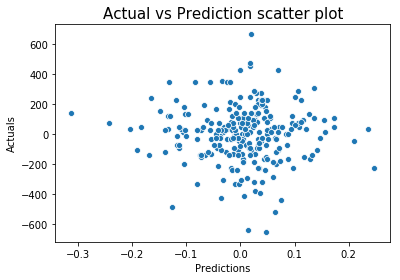

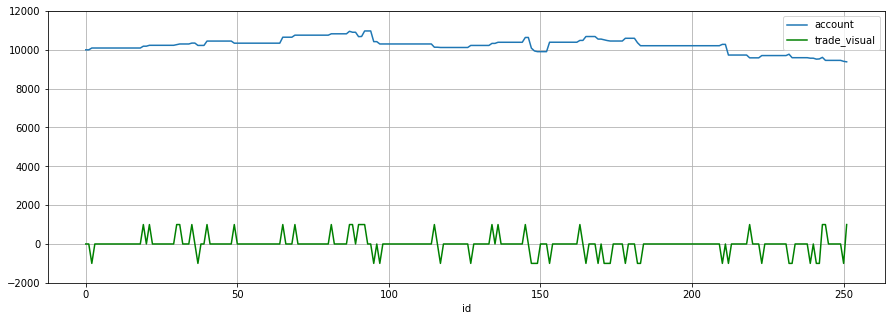

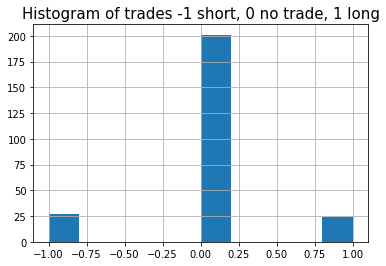

In [175]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.1, name='corn_nn_reg')

In [166]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 6s 3ms/step - loss: 133703.8479 - val_loss: 121253.1626

Epoch 00001: val_loss improved from inf to 121253.16256, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 190us/step - loss: 133693.3591 - val_loss: 121253.2223

Epoch 00002: val_loss did not improve from 121253.16256
Epoch 3/1000
1922/1922 [==============================] - 0s 190us/step - loss: 133695.3367 - val_loss: 121253.7228

Epoch 00003: val_loss did not improve from 121253.16256
Epoch 4/1000
1922/1922 [==============================] - 0s 195us/step - loss: 133693.0737 - val_loss: 121253.6766

Epoch 00004: val_loss did not improve from 121253.16256
Epoch 5/1000
1922/1922 [==============================] - 0s 191us/step - loss: 133693.6172 - val_loss: 121253.9277

Epoch 00005: val_loss did not improve from 121253.16256
Epoch 6/1000
1922/1922 [============


Epoch 00047: val_loss did not improve from 121253.16256
Epoch 48/1000
1922/1922 [==============================] - 0s 168us/step - loss: 133033.4253 - val_loss: 121433.5399

Epoch 00048: val_loss did not improve from 121253.16256
Epoch 49/1000
1922/1922 [==============================] - 0s 168us/step - loss: 133109.0205 - val_loss: 121434.2507

Epoch 00049: val_loss did not improve from 121253.16256
Epoch 50/1000
1922/1922 [==============================] - 0s 166us/step - loss: 132988.1541 - val_loss: 121433.0658

Epoch 00050: val_loss did not improve from 121253.16256
Epoch 51/1000
1922/1922 [==============================] - 0s 167us/step - loss: 133003.3803 - val_loss: 121436.2057

Epoch 00051: val_loss did not improve from 121253.16256
Epoch 52/1000
1922/1922 [==============================] - 0s 172us/step - loss: 132927.1971 - val_loss: 121442.3353

Epoch 00052: val_loss did not improve from 121253.16256
Epoch 53/1000
1922/1922 [==============================] - 0s 173us/step 

1922/1922 [==============================] - 0s 171us/step - loss: 130973.1185 - val_loss: 121724.4904

Epoch 00095: val_loss did not improve from 121253.16256
Epoch 96/1000
1922/1922 [==============================] - 0s 168us/step - loss: 130973.6442 - val_loss: 121722.3641

Epoch 00096: val_loss did not improve from 121253.16256
Epoch 97/1000
1922/1922 [==============================] - 0s 162us/step - loss: 131029.5037 - val_loss: 121725.2492

Epoch 00097: val_loss did not improve from 121253.16256
Epoch 98/1000
1922/1922 [==============================] - 0s 167us/step - loss: 130933.5689 - val_loss: 121712.0618

Epoch 00098: val_loss did not improve from 121253.16256
Epoch 99/1000
1922/1922 [==============================] - 0s 168us/step - loss: 130865.9403 - val_loss: 121706.4342

Epoch 00099: val_loss did not improve from 121253.16256
Epoch 100/1000
1922/1922 [==============================] - 0s 163us/step - loss: 130796.1369 - val_loss: 121699.5751

Epoch 00100: val_loss did

1922/1922 [==============================] - 0s 183us/step - loss: 127513.2149 - val_loss: 121971.9090

Epoch 00142: val_loss did not improve from 121253.16256
Epoch 143/1000
1922/1922 [==============================] - 0s 173us/step - loss: 127389.3105 - val_loss: 121919.8582

Epoch 00143: val_loss did not improve from 121253.16256
Epoch 144/1000
1922/1922 [==============================] - 0s 188us/step - loss: 127482.2311 - val_loss: 121922.1500

Epoch 00144: val_loss did not improve from 121253.16256
Epoch 145/1000
1922/1922 [==============================] - 0s 180us/step - loss: 127245.2586 - val_loss: 121890.9382

Epoch 00145: val_loss did not improve from 121253.16256
Epoch 146/1000
1922/1922 [==============================] - 0s 180us/step - loss: 127515.1179 - val_loss: 121880.8862

Epoch 00146: val_loss did not improve from 121253.16256
Epoch 147/1000
1922/1922 [==============================] - 0s 177us/step - loss: 126952.7152 - val_loss: 121901.7848

Epoch 00147: val_loss

1922/1922 [==============================] - 0s 173us/step - loss: 122775.7354 - val_loss: 122275.3942

Epoch 00189: val_loss did not improve from 121253.16256
Epoch 190/1000
1922/1922 [==============================] - 0s 168us/step - loss: 123129.1410 - val_loss: 122286.3964

Epoch 00190: val_loss did not improve from 121253.16256
Epoch 191/1000
1922/1922 [==============================] - 0s 157us/step - loss: 122354.3337 - val_loss: 122296.5875

Epoch 00191: val_loss did not improve from 121253.16256
Epoch 192/1000
1922/1922 [==============================] - 0s 171us/step - loss: 122551.6899 - val_loss: 122293.6478

Epoch 00192: val_loss did not improve from 121253.16256
Epoch 193/1000
1922/1922 [==============================] - 0s 170us/step - loss: 122206.3480 - val_loss: 122309.5897

Epoch 00193: val_loss did not improve from 121253.16256
Epoch 194/1000
1922/1922 [==============================] - 0s 164us/step - loss: 122059.3801 - val_loss: 122312.9584

Epoch 00194: val_loss

1922/1922 [==============================] - 0s 190us/step - loss: 117730.6860 - val_loss: 122971.9080

Epoch 00236: val_loss did not improve from 121253.16256
Epoch 237/1000
1922/1922 [==============================] - 0s 170us/step - loss: 117095.9228 - val_loss: 122950.8227

Epoch 00237: val_loss did not improve from 121253.16256
Epoch 238/1000
1922/1922 [==============================] - 0s 174us/step - loss: 116553.0664 - val_loss: 122942.1133

Epoch 00238: val_loss did not improve from 121253.16256
Epoch 239/1000
1922/1922 [==============================] - 0s 186us/step - loss: 116946.9569 - val_loss: 122944.6113

Epoch 00239: val_loss did not improve from 121253.16256
Epoch 240/1000
1922/1922 [==============================] - 0s 175us/step - loss: 116770.8565 - val_loss: 122958.4182

Epoch 00240: val_loss did not improve from 121253.16256
Epoch 241/1000
1922/1922 [==============================] - 0s 173us/step - loss: 116434.1475 - val_loss: 122981.0116

Epoch 00241: val_loss

1922/1922 [==============================] - ETA: 0s - loss: 110406.87 - 0s 164us/step - loss: 110765.2415 - val_loss: 123704.0098

Epoch 00283: val_loss did not improve from 121253.16256
Epoch 284/1000
1922/1922 [==============================] - 0s 171us/step - loss: 111433.2933 - val_loss: 123701.0452

Epoch 00284: val_loss did not improve from 121253.16256
Epoch 285/1000
1922/1922 [==============================] - 0s 194us/step - loss: 111094.9240 - val_loss: 123825.7927

Epoch 00285: val_loss did not improve from 121253.16256
Epoch 286/1000
1922/1922 [==============================] - 0s 182us/step - loss: 110929.8554 - val_loss: 123783.3479

Epoch 00286: val_loss did not improve from 121253.16256
Epoch 287/1000
1922/1922 [==============================] - 0s 157us/step - loss: 111161.1840 - val_loss: 123824.9194

Epoch 00287: val_loss did not improve from 121253.16256
Epoch 288/1000
1922/1922 [==============================] - 0s 176us/step - loss: 110379.8048 - val_loss: 123788

1922/1922 [==============================] - 0s 191us/step - loss: 104254.3993 - val_loss: 124890.2785

Epoch 00330: val_loss did not improve from 121253.16256
Epoch 331/1000
1922/1922 [==============================] - 0s 177us/step - loss: 103098.2269 - val_loss: 124940.2645

Epoch 00331: val_loss did not improve from 121253.16256
Epoch 332/1000
1922/1922 [==============================] - 0s 168us/step - loss: 103613.0296 - val_loss: 124910.4387

Epoch 00332: val_loss did not improve from 121253.16256
Epoch 333/1000
1922/1922 [==============================] - 0s 168us/step - loss: 103344.9453 - val_loss: 124970.9376

Epoch 00333: val_loss did not improve from 121253.16256
Epoch 334/1000
1922/1922 [==============================] - 0s 163us/step - loss: 103009.9920 - val_loss: 124885.3313

Epoch 00334: val_loss did not improve from 121253.16256
Epoch 335/1000
1922/1922 [==============================] - 0s 166us/step - loss: 104865.5062 - val_loss: 124895.3291

Epoch 00335: val_loss

1922/1922 [==============================] - 0s 171us/step - loss: 97033.8345 - val_loss: 125983.2496

Epoch 00377: val_loss did not improve from 121253.16256
Epoch 378/1000
1922/1922 [==============================] - 0s 169us/step - loss: 95854.6814 - val_loss: 125877.9489

Epoch 00378: val_loss did not improve from 121253.16256
Epoch 379/1000
1922/1922 [==============================] - 0s 172us/step - loss: 96737.8922 - val_loss: 125918.7435

Epoch 00379: val_loss did not improve from 121253.16256
Epoch 380/1000
1922/1922 [==============================] - 0s 168us/step - loss: 96388.1900 - val_loss: 125966.4987

Epoch 00380: val_loss did not improve from 121253.16256
Epoch 381/1000
1922/1922 [==============================] - 0s 177us/step - loss: 96892.0697 - val_loss: 126038.8244

Epoch 00381: val_loss did not improve from 121253.16256
Epoch 382/1000
1922/1922 [==============================] - 0s 175us/step - loss: 96449.6904 - val_loss: 126204.7967

Epoch 00382: val_loss did n

1922/1922 [==============================] - 0s 165us/step - loss: 90363.0866 - val_loss: 128007.8976

Epoch 00424: val_loss did not improve from 121253.16256
Epoch 425/1000
1922/1922 [==============================] - 0s 161us/step - loss: 89426.0856 - val_loss: 127754.4319

Epoch 00425: val_loss did not improve from 121253.16256
Epoch 426/1000
1922/1922 [==============================] - 0s 159us/step - loss: 90254.0167 - val_loss: 127796.1010

Epoch 00426: val_loss did not improve from 121253.16256
Epoch 427/1000
1922/1922 [==============================] - 0s 170us/step - loss: 89173.5070 - val_loss: 127791.7525

Epoch 00427: val_loss did not improve from 121253.16256
Epoch 428/1000
1922/1922 [==============================] - 0s 175us/step - loss: 88907.8054 - val_loss: 127987.1027

Epoch 00428: val_loss did not improve from 121253.16256
Epoch 429/1000
1922/1922 [==============================] - 0s 174us/step - loss: 89057.8075 - val_loss: 127967.9073

Epoch 00429: val_loss did n

1922/1922 [==============================] - 0s 164us/step - loss: 81871.6901 - val_loss: 129927.4058

Epoch 00471: val_loss did not improve from 121253.16256
Epoch 472/1000
1922/1922 [==============================] - 0s 171us/step - loss: 82705.6982 - val_loss: 129886.0907

Epoch 00472: val_loss did not improve from 121253.16256
Epoch 473/1000
1922/1922 [==============================] - 0s 170us/step - loss: 81924.1013 - val_loss: 129921.7847

Epoch 00473: val_loss did not improve from 121253.16256
Epoch 474/1000
1922/1922 [==============================] - 0s 172us/step - loss: 82550.5586 - val_loss: 130057.2204

Epoch 00474: val_loss did not improve from 121253.16256
Epoch 475/1000
1922/1922 [==============================] - 0s 168us/step - loss: 81757.0259 - val_loss: 130039.8295

Epoch 00475: val_loss did not improve from 121253.16256
Epoch 476/1000
1922/1922 [==============================] - 0s 171us/step - loss: 81998.3589 - val_loss: 130206.2612

Epoch 00476: val_loss did n

1922/1922 [==============================] - 0s 168us/step - loss: 76145.0765 - val_loss: 132285.4359

Epoch 00518: val_loss did not improve from 121253.16256
Epoch 519/1000
1922/1922 [==============================] - 0s 168us/step - loss: 74653.6118 - val_loss: 132328.0750

Epoch 00519: val_loss did not improve from 121253.16256
Epoch 520/1000
1922/1922 [==============================] - 0s 169us/step - loss: 74798.9467 - val_loss: 132160.1941

Epoch 00520: val_loss did not improve from 121253.16256
Epoch 521/1000
1922/1922 [==============================] - 0s 163us/step - loss: 75049.2354 - val_loss: 132312.6665

Epoch 00521: val_loss did not improve from 121253.16256
Epoch 522/1000
1922/1922 [==============================] - ETA: 0s - loss: 76671.901 - 0s 162us/step - loss: 75932.8265 - val_loss: 132527.9702

Epoch 00522: val_loss did not improve from 121253.16256
Epoch 523/1000
1922/1922 [==============================] - 0s 164us/step - loss: 73117.3761 - val_loss: 132079.9918


1922/1922 [==============================] - 0s 179us/step - loss: 67406.7233 - val_loss: 134815.5363

Epoch 00565: val_loss did not improve from 121253.16256
Epoch 566/1000
1922/1922 [==============================] - 0s 170us/step - loss: 67585.8548 - val_loss: 135201.3942

Epoch 00566: val_loss did not improve from 121253.16256
Epoch 567/1000
1922/1922 [==============================] - 0s 169us/step - loss: 68550.0878 - val_loss: 135442.0840

Epoch 00567: val_loss did not improve from 121253.16256
Epoch 568/1000
1922/1922 [==============================] - 0s 179us/step - loss: 66640.0811 - val_loss: 135066.4612

Epoch 00568: val_loss did not improve from 121253.16256
Epoch 569/1000
1922/1922 [==============================] - 0s 166us/step - loss: 66547.2360 - val_loss: 135081.3894

Epoch 00569: val_loss did not improve from 121253.16256
Epoch 570/1000
1922/1922 [==============================] - 0s 164us/step - loss: 68963.6428 - val_loss: 135556.7738

Epoch 00570: val_loss did n

1922/1922 [==============================] - 0s 169us/step - loss: 60404.0511 - val_loss: 138822.8554

Epoch 00612: val_loss did not improve from 121253.16256
Epoch 613/1000
1922/1922 [==============================] - 0s 162us/step - loss: 60143.8708 - val_loss: 139237.6058

Epoch 00613: val_loss did not improve from 121253.16256
Epoch 614/1000
1922/1922 [==============================] - 0s 162us/step - loss: 60247.6157 - val_loss: 139411.5865

Epoch 00614: val_loss did not improve from 121253.16256
Epoch 615/1000
1922/1922 [==============================] - 0s 181us/step - loss: 59441.0268 - val_loss: 139575.9615

Epoch 00615: val_loss did not improve from 121253.16256
Epoch 616/1000
1922/1922 [==============================] - 0s 167us/step - loss: 59233.0185 - val_loss: 139355.5920

Epoch 00616: val_loss did not improve from 121253.16256
Epoch 617/1000
1922/1922 [==============================] - 0s 163us/step - loss: 60082.0859 - val_loss: 139007.6517

Epoch 00617: val_loss did n

1922/1922 [==============================] - 0s 171us/step - loss: 55991.5814 - val_loss: 142428.7256

Epoch 00659: val_loss did not improve from 121253.16256
Epoch 660/1000
1922/1922 [==============================] - 0s 168us/step - loss: 55045.6887 - val_loss: 142711.9241

Epoch 00660: val_loss did not improve from 121253.16256
Epoch 661/1000
1922/1922 [==============================] - 0s 174us/step - loss: 54627.3491 - val_loss: 142990.2164

Epoch 00661: val_loss did not improve from 121253.16256
Epoch 662/1000
1922/1922 [==============================] - 0s 168us/step - loss: 52974.3601 - val_loss: 142893.8751

Epoch 00662: val_loss did not improve from 121253.16256
Epoch 663/1000
1922/1922 [==============================] - 0s 169us/step - loss: 54308.7595 - val_loss: 143574.6381

Epoch 00663: val_loss did not improve from 121253.16256
Epoch 664/1000
1922/1922 [==============================] - 0s 177us/step - loss: 53761.4227 - val_loss: 143958.9091

Epoch 00664: val_loss did n

1922/1922 [==============================] - 0s 164us/step - loss: 50777.9836 - val_loss: 148333.7565

Epoch 00706: val_loss did not improve from 121253.16256
Epoch 707/1000
1922/1922 [==============================] - 0s 160us/step - loss: 47660.0367 - val_loss: 148748.1174

Epoch 00707: val_loss did not improve from 121253.16256
Epoch 708/1000
1922/1922 [==============================] - 0s 169us/step - loss: 48700.0422 - val_loss: 147197.2612

Epoch 00708: val_loss did not improve from 121253.16256
Epoch 709/1000
1922/1922 [==============================] - 0s 174us/step - loss: 50077.2647 - val_loss: 147297.2294

Epoch 00709: val_loss did not improve from 121253.16256
Epoch 710/1000
1922/1922 [==============================] - 0s 171us/step - loss: 49028.8933 - val_loss: 148081.6701

Epoch 00710: val_loss did not improve from 121253.16256
Epoch 711/1000
1922/1922 [==============================] - 0s 175us/step - loss: 50360.6293 - val_loss: 148047.3379

Epoch 00711: val_loss did n

1922/1922 [==============================] - 0s 177us/step - loss: 43825.8018 - val_loss: 153049.1908

Epoch 00753: val_loss did not improve from 121253.16256
Epoch 754/1000
1922/1922 [==============================] - 0s 176us/step - loss: 43465.9856 - val_loss: 153632.5169

Epoch 00754: val_loss did not improve from 121253.16256
Epoch 755/1000
1922/1922 [==============================] - 0s 178us/step - loss: 43945.9801 - val_loss: 153816.0450

Epoch 00755: val_loss did not improve from 121253.16256
Epoch 756/1000
1922/1922 [==============================] - 0s 171us/step - loss: 44464.0846 - val_loss: 153764.4724

Epoch 00756: val_loss did not improve from 121253.16256
Epoch 757/1000
1922/1922 [==============================] - 0s 171us/step - loss: 44903.8627 - val_loss: 154032.9064

Epoch 00757: val_loss did not improve from 121253.16256
Epoch 758/1000
1922/1922 [==============================] - 0s 167us/step - loss: 43749.7141 - val_loss: 154501.5012

Epoch 00758: val_loss did n

1922/1922 [==============================] - 0s 168us/step - loss: 40429.1411 - val_loss: 159396.4046

Epoch 00800: val_loss did not improve from 121253.16256
Epoch 801/1000
1922/1922 [==============================] - 0s 171us/step - loss: 40628.5638 - val_loss: 159328.0563

Epoch 00801: val_loss did not improve from 121253.16256
Epoch 802/1000
1922/1922 [==============================] - 0s 167us/step - loss: 40995.1408 - val_loss: 159141.7832

Epoch 00802: val_loss did not improve from 121253.16256
Epoch 803/1000
1922/1922 [==============================] - 0s 167us/step - loss: 41331.1635 - val_loss: 160827.5039

Epoch 00803: val_loss did not improve from 121253.16256
Epoch 804/1000
1922/1922 [==============================] - 0s 175us/step - loss: 40348.7125 - val_loss: 159909.0440

Epoch 00804: val_loss did not improve from 121253.16256
Epoch 805/1000
1922/1922 [==============================] - 0s 171us/step - loss: 39557.3071 - val_loss: 160897.7240

Epoch 00805: val_loss did n

1922/1922 [==============================] - 0s 165us/step - loss: 36927.6803 - val_loss: 163222.5546

Epoch 00847: val_loss did not improve from 121253.16256
Epoch 848/1000
1922/1922 [==============================] - 0s 161us/step - loss: 36790.8521 - val_loss: 163145.3568

Epoch 00848: val_loss did not improve from 121253.16256
Epoch 849/1000
1922/1922 [==============================] - 0s 161us/step - loss: 36432.9619 - val_loss: 162912.7443

Epoch 00849: val_loss did not improve from 121253.16256
Epoch 850/1000
1922/1922 [==============================] - 0s 163us/step - loss: 35238.4963 - val_loss: 162460.5819

Epoch 00850: val_loss did not improve from 121253.16256
Epoch 851/1000
1922/1922 [==============================] - 0s 165us/step - loss: 38112.3051 - val_loss: 163433.5220

Epoch 00851: val_loss did not improve from 121253.16256
Epoch 852/1000
1922/1922 [==============================] - 0s 161us/step - loss: 37607.7081 - val_loss: 163442.7751

Epoch 00852: val_loss did n

1922/1922 [==============================] - 0s 170us/step - loss: 32099.3123 - val_loss: 168146.8724

Epoch 00894: val_loss did not improve from 121253.16256
Epoch 895/1000
1922/1922 [==============================] - 0s 162us/step - loss: 34420.2234 - val_loss: 168091.6904

Epoch 00895: val_loss did not improve from 121253.16256
Epoch 896/1000
1922/1922 [==============================] - 0s 174us/step - loss: 33625.8514 - val_loss: 167348.8628

Epoch 00896: val_loss did not improve from 121253.16256
Epoch 897/1000
1922/1922 [==============================] - 0s 171us/step - loss: 34241.1390 - val_loss: 168308.7028

Epoch 00897: val_loss did not improve from 121253.16256
Epoch 898/1000
1922/1922 [==============================] - 0s 172us/step - loss: 34721.5068 - val_loss: 169364.4385

Epoch 00898: val_loss did not improve from 121253.16256
Epoch 899/1000
1922/1922 [==============================] - 0s 167us/step - loss: 33335.9194 - val_loss: 169422.1558

Epoch 00899: val_loss did n

1922/1922 [==============================] - 0s 171us/step - loss: 33001.4688 - val_loss: 174561.8675

Epoch 00941: val_loss did not improve from 121253.16256
Epoch 942/1000
1922/1922 [==============================] - 0s 178us/step - loss: 34800.9096 - val_loss: 173558.9578

Epoch 00942: val_loss did not improve from 121253.16256
Epoch 943/1000
1922/1922 [==============================] - 0s 174us/step - loss: 34414.1312 - val_loss: 174217.1035

Epoch 00943: val_loss did not improve from 121253.16256
Epoch 944/1000
1922/1922 [==============================] - 0s 192us/step - loss: 30711.2237 - val_loss: 174449.9023

Epoch 00944: val_loss did not improve from 121253.16256
Epoch 945/1000
1922/1922 [==============================] - 0s 171us/step - loss: 33473.8553 - val_loss: 174321.8719

Epoch 00945: val_loss did not improve from 121253.16256
Epoch 946/1000
1922/1922 [==============================] - 0s 172us/step - loss: 31555.4200 - val_loss: 173839.9665

Epoch 00946: val_loss did n

1922/1922 [==============================] - 0s 165us/step - loss: 30895.7199 - val_loss: 179719.9779

Epoch 00988: val_loss did not improve from 121253.16256
Epoch 989/1000
1922/1922 [==============================] - 0s 165us/step - loss: 29939.6679 - val_loss: 178617.6471

Epoch 00989: val_loss did not improve from 121253.16256
Epoch 990/1000
1922/1922 [==============================] - 0s 163us/step - loss: 29632.2385 - val_loss: 178432.8275

Epoch 00990: val_loss did not improve from 121253.16256
Epoch 991/1000
1922/1922 [==============================] - 0s 164us/step - loss: 30306.0823 - val_loss: 178645.5476

Epoch 00991: val_loss did not improve from 121253.16256
Epoch 992/1000
1922/1922 [==============================] - 0s 166us/step - loss: 32330.0894 - val_loss: 180229.1037

Epoch 00992: val_loss did not improve from 121253.16256
Epoch 993/1000
1922/1922 [==============================] - 0s 170us/step - loss: 32859.8380 - val_loss: 180378.3520

Epoch 00993: val_loss did n

In [167]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  -0.00957565360232322
Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00
Precision score:  [0.         0.03571429 0.        ]


/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


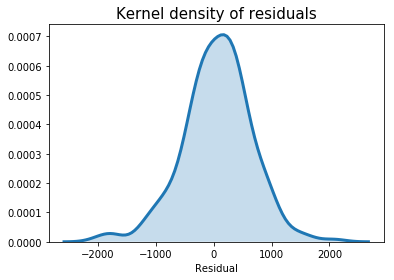

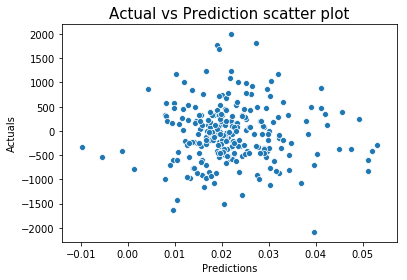

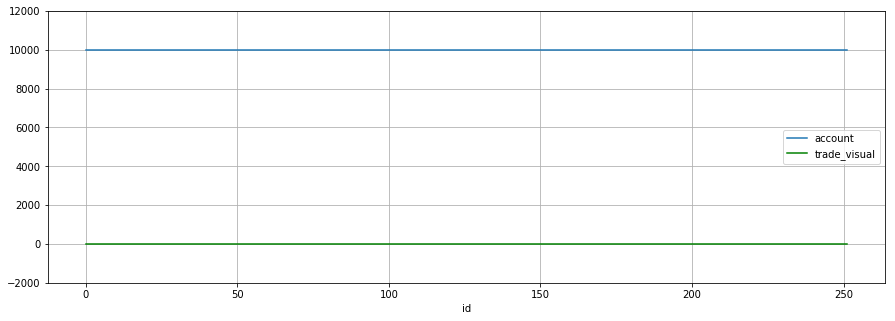

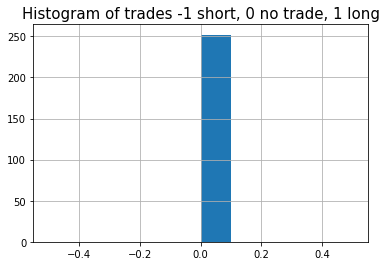

In [168]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1, name='coffee_nn_reg')

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [102]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)
/home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/connection.py:317: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  "This may interfere with your H2O Connection." % name)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.1" 2018-10-16; OpenJDK Runtime Environment (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1); OpenJDK 64-Bit Server VM (build 11.0.1+13-Ubuntu-3ubuntu3.18.10.1, mixed mode, sharing)
  Starting server from /home/martin/virtualenvs/oracle3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2ie5crcz
  JVM stdout: /tmp/tmp2ie5crcz/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmp2ie5crcz/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_martin_envm85
H2O cluster total nodes:,1
H2O cluster free memory:,2.389 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [103]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190207_154628_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
XRT_1_AutoML_20190207_154628,0.477046,0.69162,0.5,0.476521,0.227073
StackedEnsemble_AllModels_AutoML_20190207_154628,0.476126,0.60746,0.5,0.456459,0.208355
StackedEnsemble_BestOfFamily_AutoML_20190207_154628,0.476126,0.60746,0.5,0.456459,0.208355
DRF_1_AutoML_20190207_154628,0.472127,0.650638,0.494616,0.474203,0.224868


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5611bcf28>]],
      dtype=object)

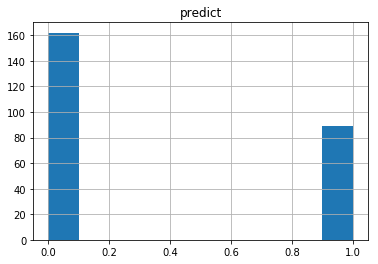

In [104]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  72.95 %
Number of trades:  89
Number of short trades:  0
Number of long trades:  89
Earnings per trade:  81.97
Earnings per short trade:  0.00
Earnings per long trade:  81.97


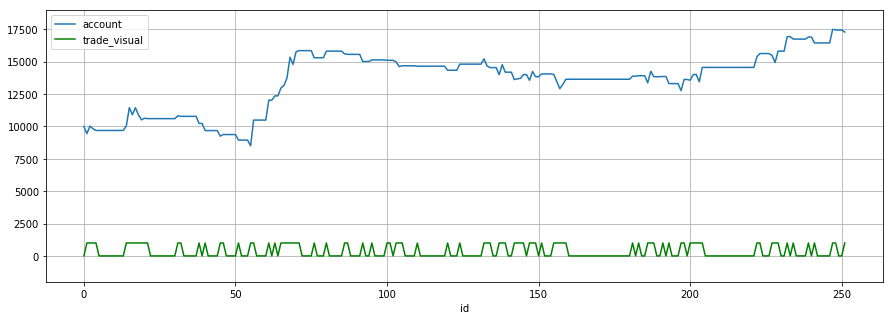

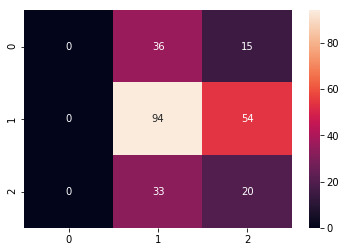

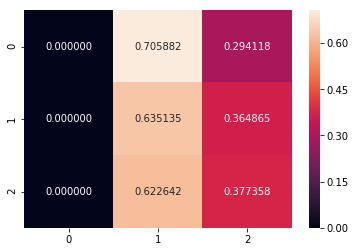

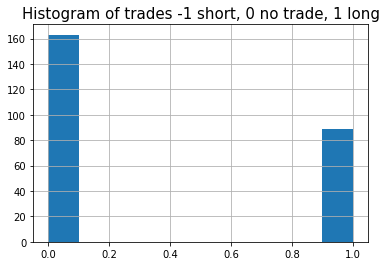

In [105]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

### H2O AutoML gold regressor

In [106]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190207_154755_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_AllModels_AutoML_20190207_154755,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_BestOfFamily_AutoML_20190207_154755,1.68533e+06,1298.2,1.68533e+06,896.418,nan
GBM_grid_1_AutoML_20190207_154755_model_9,1.6923e+06,1300.88,1.6923e+06,897.703,nan
GBM_grid_1_AutoML_20190207_154755_model_7,1.6926e+06,1301,1.6926e+06,898.466,nan
GBM_grid_1_AutoML_20190207_154755_model_6,1.69501e+06,1301.93,1.69501e+06,899.696,nan
GBM_grid_1_AutoML_20190207_154755_model_5,1.6984e+06,1303.23,1.6984e+06,898.45,nan
GBM_grid_1_AutoML_20190207_154755_model_1,1.72597e+06,1313.76,1.72597e+06,910.145,nan
GBM_grid_1_AutoML_20190207_154755_model_4,1.73897e+06,1318.7,1.73897e+06,911.332,nan
GBM_5_AutoML_20190207_154755,1.74291e+06,1320.19,1.74291e+06,920.143,nan


glm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5611c5438>]],
      dtype=object)

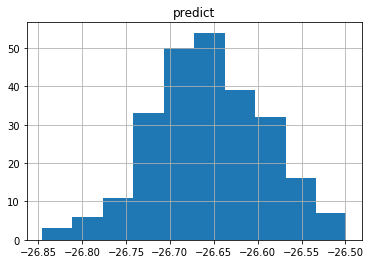

In [107]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [108]:
b

array([-26.64229968, -26.71641999, -26.708649  , -26.71515188,
       -26.63658053, -26.64446274, -26.64020086, -26.71253869,
       -26.66806547, -26.6756639 , -26.65211953, -26.64890615,
       -26.65344326, -26.61857664, -26.56154821, -26.57349536,
       -26.59273975, -26.64060133, -26.63128295, -26.66378233,
       -26.69216267, -26.72992689, -26.71783875, -26.6885868 ,
       -26.61967933, -26.58579422, -26.63610436, -26.69308651,
       -26.7082924 , -26.64246799, -26.54135393, -26.54918815,
       -26.64174458, -26.72843558, -26.78074026, -26.69889125,
       -26.73783544, -26.65964022, -26.65177147, -26.68606529,
       -26.67097812, -26.69366353, -26.6849714 , -26.6581517 ,
       -26.5768978 , -26.57849511, -26.66287907, -26.70672685,
       -26.70472282, -26.69631531, -26.64723116, -26.68017371,
       -26.64785677, -26.59564131, -26.63087327, -26.58388114,
       -26.62635637, -26.76022761, -26.7412088 , -26.68790975,
       -26.69833714, -26.70706475, -26.68660787, -26.66

In [109]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [110]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Returns  0.00 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00


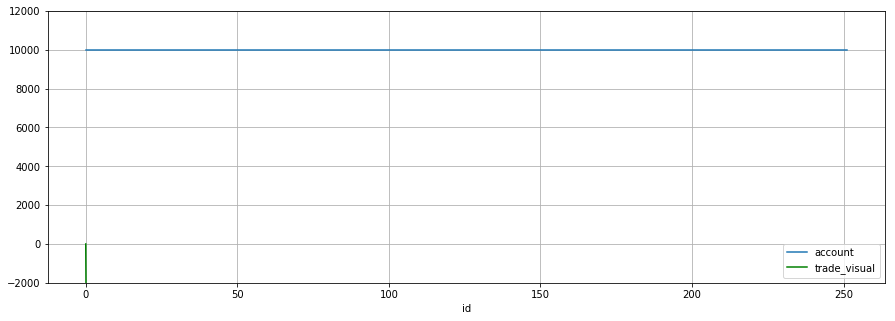

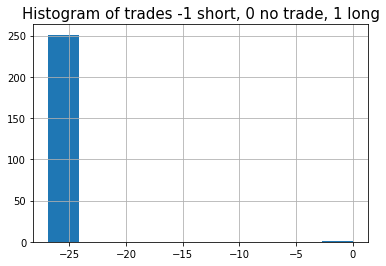

In [111]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True)

### H2O short trade

In [112]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_4_AutoML_20190207_155725,0.519649,0.652706,0.498539,0.472855,0.223592
GBM_grid_1_AutoML_20190207_155725_model_9,0.518424,1.12159,0.5,0.525174,0.275808
GBM_grid_1_AutoML_20190207_155725_model_7,0.517231,0.749949,0.5,0.498757,0.248758
GBM_1_AutoML_20190207_155725,0.514903,0.63345,0.499635,0.467266,0.218337
DRF_1_AutoML_20190207_155725,0.514799,0.644456,0.49188,0.470246,0.221131
GBM_grid_1_AutoML_20190207_155725_model_6,0.510856,0.603947,0.5,0.454695,0.206748
GBM_5_AutoML_20190207_155725,0.507968,0.616868,0.496502,0.460257,0.211836
GBM_grid_1_AutoML_20190207_155725_model_5,0.50742,0.604007,0.494704,0.454722,0.206772
GBM_3_AutoML_20190207_155725,0.503352,0.648492,0.495926,0.472189,0.222962
GBM_grid_1_AutoML_20190207_155725_model_3,0.502599,0.615589,0.5,0.459708,0.211331


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb560f5e9b0>]],
      dtype=object)

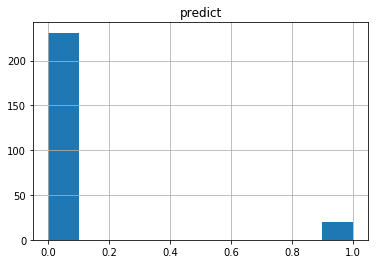

In [113]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  56.01 %
Number of trades:  20
Number of short trades:  20
Number of long trades:  0
Earnings per trade:  280.07
Earnings per short trade:  280.07
Earnings per long trade:  0.00


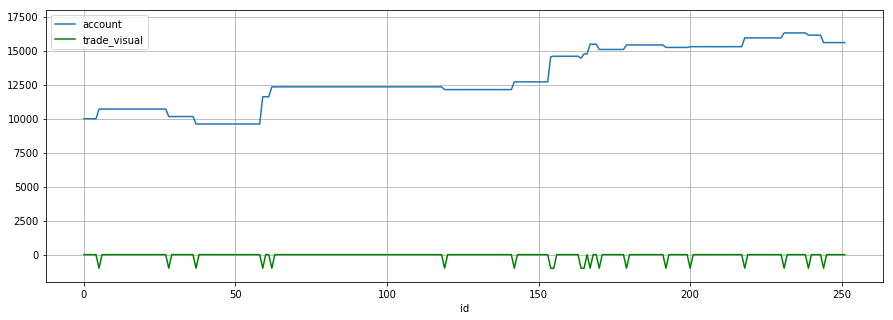

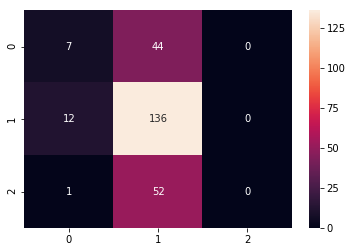

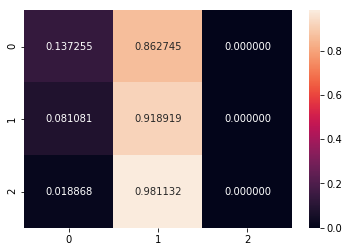

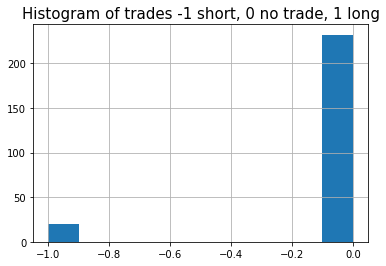

In [114]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800)

In [115]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20190207_160733_model_3,0.542602,0.598815,0.473194,0.452171,0.204458
GBM_5_AutoML_20190207_160733,0.533986,0.608311,0.498179,0.456043,0.207975
GBM_grid_1_AutoML_20190207_160733_model_5,0.533266,0.599328,0.459379,0.452441,0.204703
GBM_1_AutoML_20190207_160733,0.530715,0.622389,0.487948,0.461382,0.212874
DeepLearning_grid_1_AutoML_20190207_160733_model_1,0.528913,2.04514,0.5,0.564105,0.318215
DRF_1_AutoML_20190207_160733,0.528342,0.660491,0.5,0.464089,0.215378
GBM_4_AutoML_20190207_160733,0.52617,0.641655,0.499272,0.465791,0.216961
GBM_3_AutoML_20190207_160733,0.525998,0.635475,0.499636,0.464675,0.215923
GBM_grid_1_AutoML_20190207_160733_model_1,0.525667,0.599714,0.487542,0.452573,0.204822
GBM_2_AutoML_20190207_160733,0.522005,0.627753,0.49563,0.462955,0.214328


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb560e3a978>]],
      dtype=object)

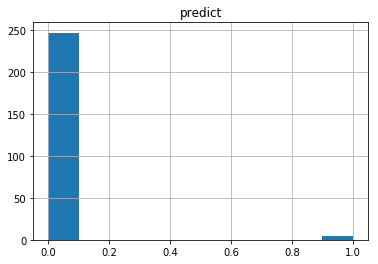

In [116]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  4.69 %
Number of trades:  4
Number of short trades:  4
Number of long trades:  0
Earnings per trade:  117.25
Earnings per short trade:  117.25
Earnings per long trade:  0.00


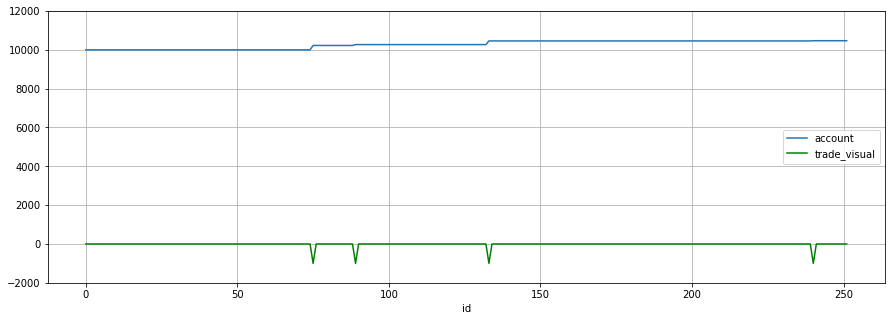

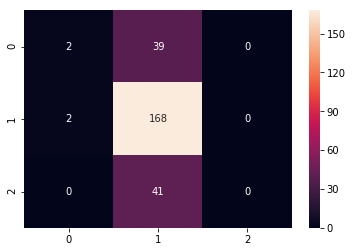

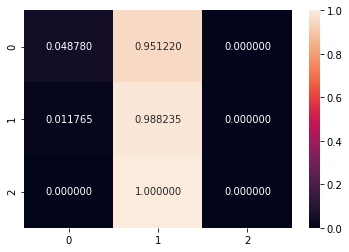

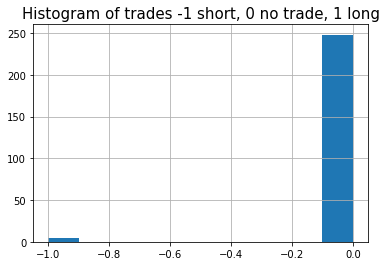

In [117]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [118]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_1_AutoML_20190207_161659,0.545483,0.631149,0.486863,0.466671,0.217782
StackedEnsemble_BestOfFamily_AutoML_20190207_161659,0.542098,0.613183,0.480375,0.459596,0.211229
GBM_4_AutoML_20190207_161659,0.53766,0.651727,0.498509,0.47314,0.223861
DeepLearning_grid_1_AutoML_20190207_161659_model_1,0.533907,2.06138,0.5,0.570499,0.325469
GBM_5_AutoML_20190207_161659,0.532961,0.623489,0.499627,0.464026,0.21532
StackedEnsemble_AllModels_AutoML_20190207_161659,0.530244,0.614126,0.485388,0.46001,0.21161
GBM_grid_1_AutoML_20190207_161659_model_5,0.528271,0.61419,0.473213,0.460061,0.211656
GBM_grid_1_AutoML_20190207_161659_model_3,0.525618,0.614071,0.475957,0.459999,0.211599
GBM_grid_1_AutoML_20190207_161659_model_1,0.523735,0.614736,0.499254,0.460275,0.211853
XRT_1_AutoML_20190207_161659,0.521799,0.642431,0.495296,0.47096,0.221803


gbm prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb561257f98>]],
      dtype=object)

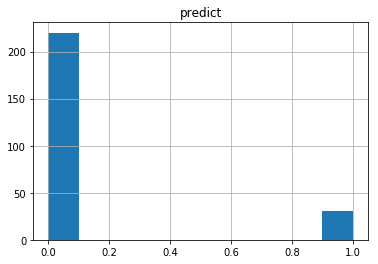

In [119]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  -14.59 %
Number of trades:  31
Number of short trades:  0
Number of long trades:  31
Earnings per trade:  -47.06
Earnings per short trade:  0.00
Earnings per long trade:  -47.06


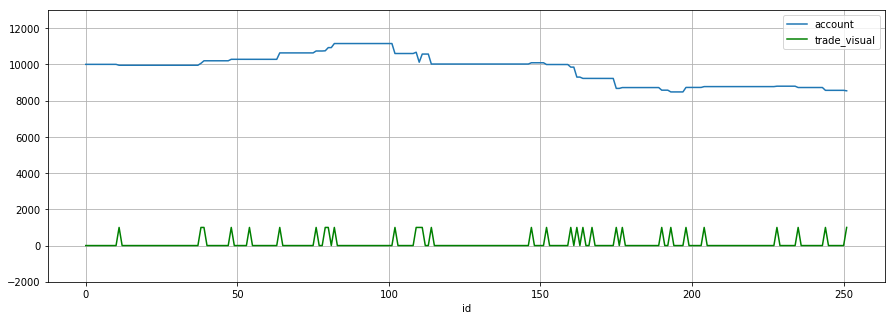

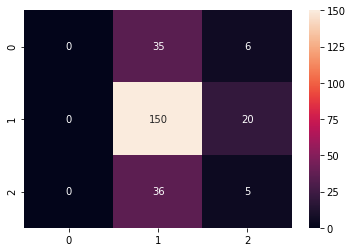

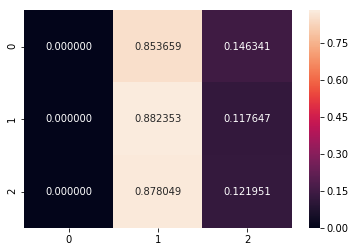

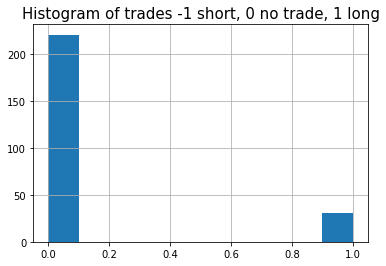

In [120]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300)

In [121]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190207_162625_model_3,0.532605,1.13938,0.5,0.566751,0.321207
GLM_grid_1_AutoML_20190207_162625_model_1,0.527217,0.658517,0.5,0.482574,0.232877
DeepLearning_grid_1_AutoML_20190207_162625_model_1,0.527132,2.09771,0.5,0.612409,0.375045
DeepLearning_grid_1_AutoML_20190207_162625_model_2,0.524419,1.36428,0.5,0.591347,0.349691
GBM_5_AutoML_20190207_162625,0.519542,0.668057,0.493053,0.486933,0.237104
GBM_1_AutoML_20190207_162625,0.518702,0.686336,0.5,0.49393,0.243967
GBM_4_AutoML_20190207_162625,0.514719,0.703042,0.499587,0.500172,0.250172
GBM_2_AutoML_20190207_162625,0.510637,0.691967,0.499053,0.496575,0.246587
GBM_grid_1_AutoML_20190207_162625_model_2,0.509639,1.26803,0.491646,0.576808,0.332708
DeepLearning_1_AutoML_20190207_162625,0.506667,0.794375,0.497815,0.525823,0.27649


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  -37.70 %
Number of trades:  107
Number of short trades:  0
Number of long trades:  107
Earnings per trade:  -35.24
Earnings per short trade:  0.00
Earnings per long trade:  -35.24


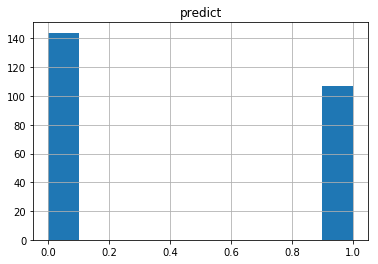

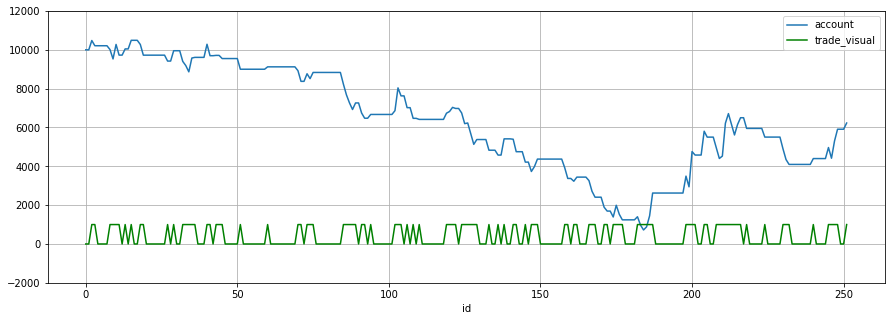

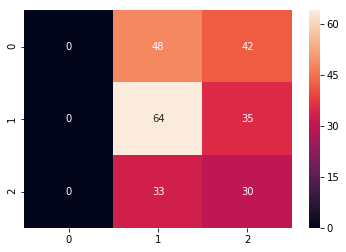

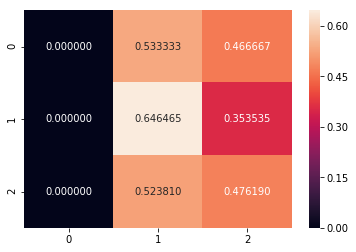

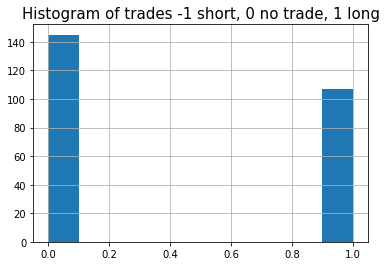

In [122]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

In [123]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_20190207_163600_model_4,0.513272,1.06025,0.495019,0.564556,0.318723
GBM_2_AutoML_20190207_163600,0.511064,0.698649,0.497471,0.500544,0.250544
DeepLearning_grid_1_AutoML_20190207_163600_model_2,0.509781,2.83244,0.5,0.647665,0.41947
GBM_4_AutoML_20190207_163600,0.506362,0.716539,0.5,0.506089,0.256126
GBM_3_AutoML_20190207_163600,0.502403,0.706331,0.5,0.502838,0.252846
GLM_grid_1_AutoML_20190207_163600_model_1,0.498935,0.666653,0.498733,0.486688,0.236866
XRT_1_AutoML_20190207_163600,0.498353,0.7057,0.498987,0.503283,0.253294
GBM_grid_1_AutoML_20190207_163600_model_2,0.497287,1.33192,0.5,0.5906,0.348809
StackedEnsemble_AllModels_AutoML_20190207_163600,0.497095,0.666139,0.5,0.486434,0.236618
DRF_1_AutoML_20190207_163600,0.496928,0.706637,0.498733,0.503576,0.253589


deeplearning prediction progress: |███████████████████████████████████████| 100%
Returns  204.28 %
Number of trades:  248
Number of short trades:  248
Number of long trades:  0
Earnings per trade:  82.37
Earnings per short trade:  82.37
Earnings per long trade:  0.00


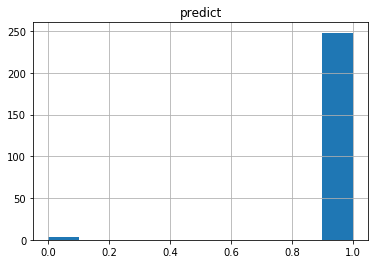

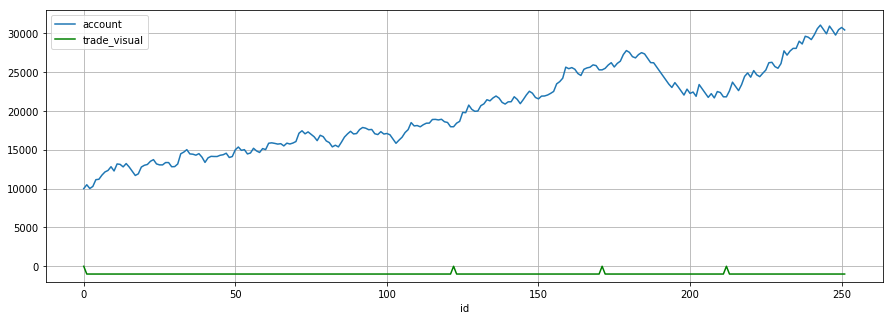

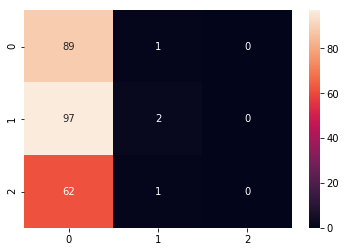

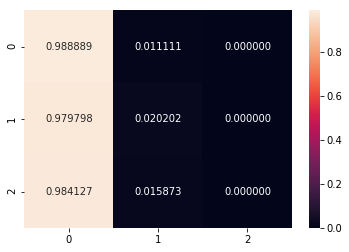

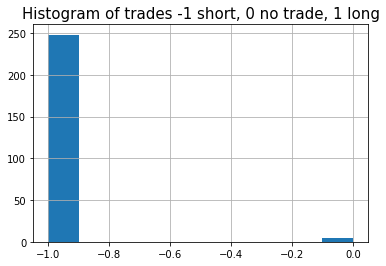

In [124]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800)

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [125]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

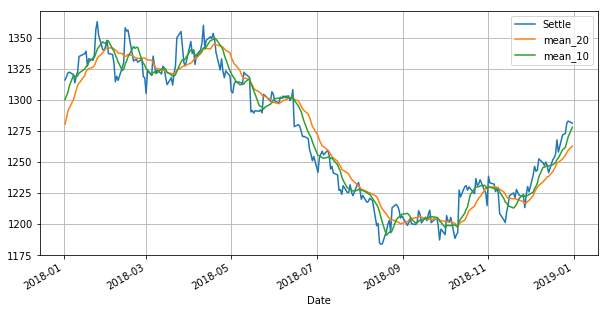

In [126]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [127]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [128]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [129]:
nasdaq_amount

1.5349783184312522

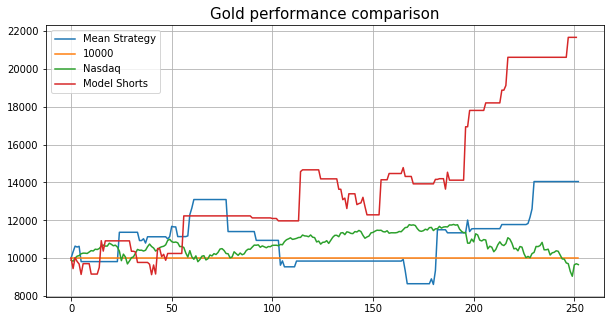

In [130]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [131]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9894.853985
1,10332.5,10000,9837.292298
2,10636.5,10000,10000.000000
3,10589.0,10000,10107.064738
4,10627.0,10000,10136.229326


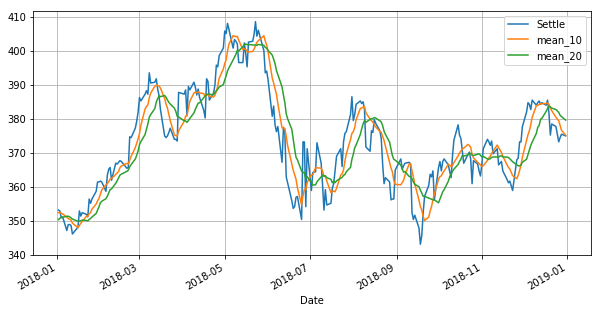

In [132]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

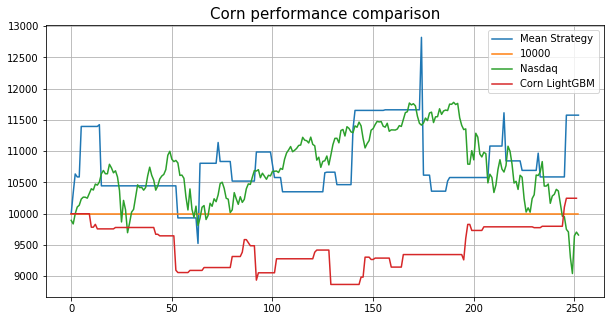

In [133]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)

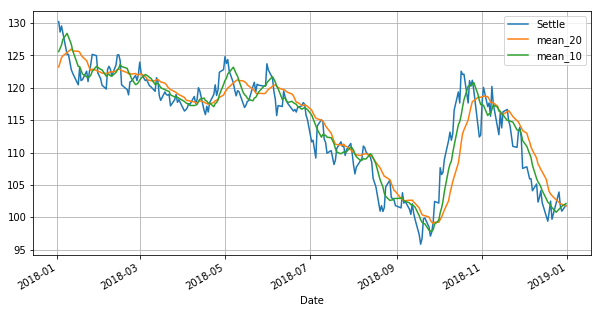

In [134]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

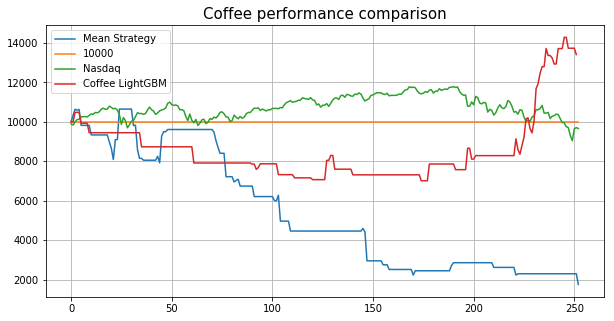

In [135]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.